In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-08-14 14:07:09.679638: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-08-14 14:07:11.246174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:3b:00.0
2024-08-14 14:07:11.246429: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-08-14 14:07:11.247819: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-08-14 14:07:11.249012: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-08-14 14:07:11.249321: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-08-14 14:07:11.250852: I tensorflow/stream_executor/platform/d

In [15]:
#Reading files into a log
import sys
import logging

nblog = open("nb_id.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [3]:
np.random.seed(42)

In [4]:
tf.random.set_seed(8)

In [5]:
# Defining the CWoLA model
def CWoLA(p_i):
    
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_1")
    #x = keras.layers.Input(shape = (p_i,p_i,2), name = "jet1and2")
    #input_1 = keras.layers.Lambda(lambda x: x[:,:,:,0:1])
    #input_2 = keras.layers.Lambda(lambda x: x[:,:,:,1:2])
    #y = input_1(x)
    #z = input_2(x)
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_2")    
    input_3 = keras.layers.Input(shape = (2), name = "all_1")
    input_4 = keras.layers.Input(shape = (2), name = "all_2")
    
    
    y = keras.layers.BatchNormalization()(input_1)
    z = keras.layers.BatchNormalization()(input_2)  

    y_1 = keras.layers.BatchNormalization()(input_3)
    z_1 = keras.layers.BatchNormalization()(input_4)
    
    y_2 = keras.layers.Concatenate()([y_1, z_1])
    
    z_2 = keras.layers.Concatenate()([y, z])
    cnn = keras.Sequential([
        keras.layers.Conv2D(64, (5,5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(64, (5, 5), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        keras.layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
        keras.layers.Flatten(),
    ])
        
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    ann = keras.Sequential([keras.layers.Dense(128, activation = 'relu'),
                            keras.layers.Dense(128, activation = 'relu'),
                            keras.layers.Dense(1, activation = 'sigmoid')
    ])
    x_1 = dnn(cnn(z_2))
    x_3 = ann(y_2)
    x_out = x_3
    #x_out = keras.layers.Multiply()([x_1, x_3])
    return keras.Model(         
    inputs=[input_1, input_2, input_3, input_4],
    outputs=x_out)





In [6]:
n_train_sr_bkg = 25000
mean_results = []
std_results = []
for p_1 in [25]:#[25, 50, 75]:#[25, 50, 75]:
    rng = np.random.default_rng(seed = 42)    
    os.chdir('/home/manhducnmd/pp_dijet/Results_full')    
    bkg_sr_jet_1 = np.load(f'retest_full_background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'retest_full_background_images_sr_{p_1}_jet_2.npy')
    
    bkg_sr_mass_jet_1 = np.load(f'test_full_background_sr_mass_jet_1.npy')
    bkg_sr_mass_jet_2 = np.load(f'test_full_background_sr_mass_jet_2.npy')
    
    bkg_sr_eta_jet_1 = np.load(f'test_full_background_sr_eta_jet_1.npy')
    bkg_sr_eta_jet_2 = np.load(f'test_full_background_sr_eta_jet_2.npy')
    
    bkg_sr_phi_jet_1 = np.load(f'test_full_background_sr_phi_jet_1.npy')
    bkg_sr_phi_jet_2 = np.load(f'test_full_background_sr_phi_jet_2.npy')
    
    bkg_sr_lha_jet_1 = np.load(f'test_full_background_sr_lha_jet_1.npy')
    bkg_sr_lha_jet_2 = np.load(f'test_full_background_sr_lha_jet_2.npy')
    
    bkg_sr_all_variables_jet_1 = np.stack((bkg_sr_mass_jet_1, bkg_sr_lha_jet_1)
                                         , axis = -1)
    bkg_sr_all_variables_jet_2 = np.stack((bkg_sr_mass_jet_2, bkg_sr_lha_jet_2)
                                         , axis = -1)
    
    
    bkg_sb_jet_1 = np.load(f'retest_full_background_images_sb_{p_1}_jet_1.npy')
    bkg_sb_jet_2 = np.load(f'retest_full_background_images_sb_{p_1}_jet_2.npy')
    
    bkg_sb_mass_jet_1 = np.load(f'test_full_background_sb_mass_jet_1.npy')
    bkg_sb_mass_jet_2 = np.load(f'test_full_background_sb_mass_jet_2.npy')
    
    bkg_sb_eta_jet_1 = np.load(f'test_full_background_sb_eta_jet_1.npy')
    bkg_sb_eta_jet_2 = np.load(f'test_full_background_sb_eta_jet_2.npy')
    
    bkg_sb_phi_jet_1 = np.load(f'test_full_background_sb_phi_jet_1.npy')
    bkg_sb_phi_jet_2 = np.load(f'test_full_background_sb_phi_jet_2.npy')
    
    bkg_sb_lha_jet_1 = np.load(f'test_full_background_sb_lha_jet_1.npy')
    bkg_sb_lha_jet_2 = np.load(f'test_full_background_sb_lha_jet_2.npy')
    
    bkg_sb_all_variables_jet_1 = np.stack((bkg_sb_mass_jet_1, bkg_sb_lha_jet_1)
                                         , axis = -1)
    bkg_sb_all_variables_jet_2 = np.stack((bkg_sb_mass_jet_2, bkg_sb_lha_jet_2)
                                         , axis = -1)
    
    
    sb_sr_bkg = np.shape(bkg_sb_jet_1)[0]/np.shape(bkg_sr_jet_2)[0]
    n_train_sb_bkg = int(np.round(n_train_sr_bkg*sb_sr_bkg))
    n_test_sr_bkg = 20000
    
    #First jet, background, SR
    bkg_pretrain_sr_1 = bkg_sr_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SR
    bkg_pretrain_sr_2 = bkg_sr_jet_2[0:-n_test_sr_bkg]
    #Mass ratio, SR
    bkg_pretrain_sr_all_variables_jet_1 = bkg_sr_all_variables_jet_1[0:-n_test_sr_bkg]
    bkg_pretrain_sr_all_variables_jet_2 = bkg_sr_all_variables_jet_2[0:-n_test_sr_bkg]
    #First jet, background, SB
    bkg_pretrain_sb_1 = bkg_sb_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SB
    bkg_pretrain_sb_2 = bkg_sb_jet_2[0:-n_test_sr_bkg]
    #Mass ratio, SB
    bkg_pretrain_sb_all_variables_jet_1 = bkg_sb_all_variables_jet_1[0:-n_test_sr_bkg]
    bkg_pretrain_sb_all_variables_jet_2 = bkg_sb_all_variables_jet_2[0:-n_test_sr_bkg]
    
    signal_sr_jet_1 = np.load(f'm_id10_sr_{p_1}_jet_1.npy')
    signal_sr_jet_2 = np.load(f'm_id10_sr_{p_1}_jet_2.npy')
    
    signal_sr_mass_jet_1 = np.load(f'id10_sr_mass_jet_1.npy')
    signal_sr_mass_jet_2 = np.load(f'id10_sr_mass_jet_2.npy')
    
    signal_sr_eta_jet_1 = np.load(f'id10_sr_eta_jet_1.npy')
    signal_sr_eta_jet_2 = np.load(f'id10_sr_eta_jet_2.npy')
    
    signal_sr_phi_jet_1 = np.load(f'id10_sr_phi_jet_1.npy')
    signal_sr_phi_jet_2 = np.load(f'id10_sr_phi_jet_2.npy')
    
    signal_sr_lha_jet_1 = np.load(f'id10_sr_lha_jet_1.npy')
    signal_sr_lha_jet_2 = np.load(f'id10_sr_lha_jet_2.npy')
    
    signal_sr_all_variables_jet_1 = np.stack((signal_sr_mass_jet_1, signal_sr_lha_jet_1
                                              ), axis = -1)
    signal_sr_all_variables_jet_2 = np.stack((signal_sr_mass_jet_2, signal_sr_lha_jet_2
                                             ), axis = -1)
    
    
    signal_sb_jet_1 = np.load(f'm_id10_sb_{p_1}_jet_1.npy')
    signal_sb_jet_2 = np.load(f'm_id10_sb_{p_1}_jet_2.npy')
    
    signal_sb_mass_jet_1 = np.load(f'id10_sb_mass_jet_1.npy')
    signal_sb_mass_jet_2 = np.load(f'id10_sb_mass_jet_2.npy')
    
    signal_sb_eta_jet_1 = np.load(f'id10_sb_eta_jet_1.npy')
    signal_sb_eta_jet_2 = np.load(f'id10_sb_eta_jet_2.npy')
    
    signal_sb_phi_jet_1 = np.load(f'id10_sb_phi_jet_1.npy')
    signal_sb_phi_jet_2 = np.load(f'id10_sb_phi_jet_2.npy')
    
    signal_sb_lha_jet_1 = np.load(f'id10_sb_lha_jet_1.npy')
    signal_sb_lha_jet_2 = np.load(f'id10_sb_lha_jet_2.npy')
    
    signal_sb_all_variables_jet_1 = np.stack((signal_sb_mass_jet_1, signal_sb_lha_jet_1
                                             ), axis = -1)
    signal_sb_all_variables_jet_2 = np.stack((signal_sb_mass_jet_2, signal_sb_lha_jet_2 
                                             ), axis = -1)
    
    
    sb_sr_signal = np.shape(signal_sb_jet_1)[0]/np.shape(signal_sr_jet_1)[0]
    for n_train_sr_signal in [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
        significance = np.sqrt(2*((n_train_sr_signal+25000)*np.log(n_train_sr_signal/25000 + 1) - n_train_sr_signal))
        
        n_train_sb_signal = int(np.round(n_train_sr_signal*sb_sr_signal))
        n_test_sr_signal = 20000
        
        #First jet, signal, SR
        signal_pretrain_sr_1 = signal_sr_jet_1[0:20000] #10000 events are pooled for resampling
        
        #Second jet, signal, SR
        signal_pretrain_sr_2 = signal_sr_jet_2[0:20000]
        
        #Mass ratio, SR
        signal_pretrain_sr_all_variables_jet_1 = signal_sr_all_variables_jet_1[0:20000]
        signal_pretrain_sr_all_variables_jet_2 = signal_sr_all_variables_jet_2[0:20000]

        #First jet, signal, SB
        signal_pretrain_sb_1 = signal_sb_jet_1[0:20000]

        #Second jet, signal, SB
        signal_pretrain_sb_2 = signal_sb_jet_2[0:20000]
        
        #Mass ratio, SB
        signal_pretrain_sb_all_variables_jet_1 = signal_sb_all_variables_jet_1[0:20000]
        signal_pretrain_sb_all_variables_jet_2 = signal_sb_all_variables_jet_2[0:20000]
        
        rng_2 = np.random.default_rng(seed=42)
        
        rng_3 = np.random.default_rng(seed=42)
        for i in range(10):
            indices_2 = rng_2.permutation(np.shape(bkg_pretrain_sr_1)[0])
            
            indices_3 = rng_3.permutation(np.shape(signal_pretrain_sr_1)[0])
            
            #First jet, background, SR
            bkg_train_sr_1 = (bkg_pretrain_sr_1[indices_2])[0:n_train_sr_bkg]
            #Second jet, background, SR
            bkg_train_sr_2 = (bkg_pretrain_sr_2[indices_2])[0:n_train_sr_bkg]
            #Mass ratio, background, SR
            bkg_train_sr_all_variables_jet_1 = (bkg_pretrain_sr_all_variables_jet_1[indices_2])[0:n_train_sr_bkg]
            bkg_train_sr_all_variables_jet_2 = (bkg_pretrain_sr_all_variables_jet_2[indices_2])[0:n_train_sr_bkg]

            
            #First jet, background, SB
            bkg_train_sb_1 = (bkg_pretrain_sb_1[indices_2])[0:n_train_sb_bkg]
            #Second jet, background, SB
            bkg_train_sb_2 = (bkg_pretrain_sb_2[indices_2])[0:n_train_sb_bkg]
            #Mass ratio, background, SB
            bkg_train_sb_all_variables_jet_1 = (bkg_pretrain_sb_all_variables_jet_1[indices_2])[0:n_train_sb_bkg]
            bkg_train_sb_all_variables_jet_2 = (bkg_pretrain_sb_all_variables_jet_2[indices_2])[0:n_train_sb_bkg]

            
            signal_train_sr_1 = (signal_pretrain_sr_1[indices_3])[0:n_train_sr_signal]
            signal_train_sr_2 = (signal_pretrain_sr_2[indices_3])[0:n_train_sr_signal]
            signal_train_sr_all_variables_jet_1 = (signal_pretrain_sr_all_variables_jet_1[indices_3])[0:n_train_sr_signal]
            signal_train_sr_all_variables_jet_2 = (signal_pretrain_sr_all_variables_jet_2[indices_3])[0:n_train_sr_signal]
            
            signal_train_sb_1 = (signal_pretrain_sb_1[indices_3])[0:n_train_sb_signal]
            signal_train_sb_2 = (signal_pretrain_sb_2[indices_3])[0:n_train_sb_signal]
            signal_train_sb_all_variables_jet_1 = (signal_pretrain_sb_all_variables_jet_1[indices_3])[0:n_train_sb_signal]
            signal_train_sb_all_variables_jet_2 = (signal_pretrain_sb_all_variables_jet_2[indices_3])[0:n_train_sb_signal]
            
            train_sr_1 = np.concatenate((signal_train_sr_1, bkg_train_sr_1))
            train_sr_2 = np.concatenate((signal_train_sr_2, bkg_train_sr_2))
            train_sr_all_variables_jet_1 = np.concatenate((signal_train_sr_all_variables_jet_1, 
                                                           bkg_train_sr_all_variables_jet_1))
            train_sr_all_variables_jet_2 = np.concatenate((signal_train_sr_all_variables_jet_2, 
                                                           bkg_train_sr_all_variables_jet_2))

            train_label_sr = np.ones(np.shape(train_sr_1)[0], dtype = int)

            train_sb_1 = np.concatenate((signal_train_sb_1, bkg_train_sb_1))
            train_sb_2 = np.concatenate((signal_train_sb_2, bkg_train_sb_2))
            train_sb_all_variables_jet_1 = np.concatenate((signal_train_sb_all_variables_jet_1, 
                                                           bkg_train_sb_all_variables_jet_1))
            train_sb_all_variables_jet_2 = np.concatenate((signal_train_sb_all_variables_jet_2, 
                                                           bkg_train_sb_all_variables_jet_2))
            train_label_sb = np.zeros(np.shape(train_sb_1)[0], dtype = int)
            
            x_train_1 = np.concatenate((train_sr_1, train_sb_1))
            x_train_2 = np.concatenate((train_sr_2, train_sb_2))
            x_train_all_variables_jet_1 = np.concatenate((train_sr_all_variables_jet_1, train_sb_all_variables_jet_1))
            x_train_all_variables_jet_2 = np.concatenate((train_sr_all_variables_jet_2, train_sb_all_variables_jet_2))
            y_train = np.concatenate((train_label_sr, train_label_sb))

            #Mix up the samples
            indices = rng.permutation(np.shape(y_train)[0])

            x_train_1 = x_train_1[indices]
            x_train_2 = x_train_2[indices]
            #x_train = np.stack([x_train_1, x_train_2], axis = -1)
            x_train_all_variables_jet_1 = x_train_all_variables_jet_1[indices]
            x_train_all_variables_jet_2 = x_train_all_variables_jet_2[indices]
            y_train = y_train[indices]

            x_train_1 = x_train_1.reshape((np.shape(x_train_1)[0], p_1, p_1, 1))
            x_train_2 = x_train_2.reshape((np.shape(x_train_2)[0], p_1, p_1, 1))

            print(f'Training with significance = {significance:.2f}, run {i}')
            
            cwola = CWoLA(p_1)
            loss_object = keras.losses.BinaryCrossentropy()
            optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
            cwola.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
            early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
            #history = cwola.fit(x_train, y_train, validation_split = 0.2,
                                #shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
            history = cwola.fit({'jet_1': x_train_1, 'jet_2': x_train_2, 'all_1': x_train_all_variables_jet_1, 
                                 'all_2': x_train_all_variables_jet_2}, 
                                y_train, validation_split = 0.2,
                                  shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
            cwola.save(f'/home/manhducnmd/pp_dijet/Model_results/one_run_{i}_id10_{n_train_sr_signal}_{p_1}.keras')

Training with significance = 0.32, run 0


2024-08-14 14:08:07.363633: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-08-14 14:08:07.400795: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3200000000 Hz
2024-08-14 14:08:07.403680: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55936b515160 executing computations on platform Host. Devices:
2024-08-14 14:08:07.403719: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2024-08-14 14:08:07.406515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:3b:00.0
2024-08-14 14:08:07.406651: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-08-14 14:08:07.406688: I tensorflow/strea

Train on 40901 samples, validate on 10226 samples
Epoch 1/1000


2024-08-14 14:08:09.396239: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


40901/40901 [==============================] - 2s 41us/sample - loss: 0.6944 - accuracy: 0.5038 - val_loss: 0.6935 - val_accuracy: 0.4878
Epoch 2/1000
40901/40901 [==============================] - 1s 14us/sample - loss: 0.6930 - accuracy: 0.5077 - val_loss: 0.6932 - val_accuracy: 0.5004
Epoch 3/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6929 - accuracy: 0.5108 - val_loss: 0.6929 - val_accuracy: 0.5086
Epoch 4/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6928 - accuracy: 0.5111 - val_loss: 0.6929 - val_accuracy: 0.5104
Epoch 5/1000
40901/40901 [==============================] - 1s 12us/sample - loss: 0.6927 - accuracy: 0.5139 - val_loss: 0.6929 - val_accuracy: 0.5109
Epoch 6/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6927 - accuracy: 0.5138 - val_loss: 0.6927 - val_accuracy: 0.5151
Epoch 7/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6926 - accuracy: 0.514

40901/40901 [==============================] - 1s 14us/sample - loss: 0.6920 - accuracy: 0.5179 - val_loss: 0.6925 - val_accuracy: 0.5182
Epoch 56/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5186 - val_loss: 0.6924 - val_accuracy: 0.5217
Epoch 57/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5194 - val_loss: 0.6923 - val_accuracy: 0.5167
Epoch 58/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5177 - val_loss: 0.6924 - val_accuracy: 0.5186
Epoch 59/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5190 - val_loss: 0.6924 - val_accuracy: 0.5181
Epoch 60/1000
40901/40901 [==============================] - 1s 12us/sample - loss: 0.6920 - accuracy: 0.5186 - val_loss: 0.6924 - val_accuracy: 0.5212
Epoch 61/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy:

Epoch 109/1000
40901/40901 [==============================] - 1s 12us/sample - loss: 0.6916 - accuracy: 0.5211 - val_loss: 0.6924 - val_accuracy: 0.5185
Epoch 110/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5216 - val_loss: 0.6926 - val_accuracy: 0.5153
Epoch 111/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5197 - val_loss: 0.6924 - val_accuracy: 0.5170
Epoch 112/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5205 - val_loss: 0.6925 - val_accuracy: 0.5177
Epoch 113/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5206 - val_loss: 0.6923 - val_accuracy: 0.5174
Epoch 114/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5201 - val_loss: 0.6924 - val_accuracy: 0.5181
Epoch 115/1000
40901/40901 [==============================] - 1s 13us/sample - los

40901/40901 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5177 - val_loss: 0.6918 - val_accuracy: 0.5202
Epoch 47/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5215 - val_loss: 0.6918 - val_accuracy: 0.5237
Epoch 48/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5225 - val_loss: 0.6918 - val_accuracy: 0.5212
Epoch 49/1000
40901/40901 [==============================] - 1s 14us/sample - loss: 0.6918 - accuracy: 0.5206 - val_loss: 0.6925 - val_accuracy: 0.5124
Epoch 50/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5202 - val_loss: 0.6919 - val_accuracy: 0.5198
Epoch 51/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5198 - val_loss: 0.6920 - val_accuracy: 0.5220
Epoch 52/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy:

40901/40901 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5201 - val_loss: 0.6931 - val_accuracy: 0.5111
Epoch 35/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5213 - val_loss: 0.6933 - val_accuracy: 0.5093
Epoch 36/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5205 - val_loss: 0.6930 - val_accuracy: 0.5075
Epoch 37/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5202 - val_loss: 0.6929 - val_accuracy: 0.5105
Epoch 38/1000
40901/40901 [==============================] - 1s 14us/sample - loss: 0.6918 - accuracy: 0.5224 - val_loss: 0.6928 - val_accuracy: 0.5119
Epoch 39/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5199 - val_loss: 0.6931 - val_accuracy: 0.5116
Epoch 40/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy:

40901/40901 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5193 - val_loss: 0.6929 - val_accuracy: 0.5099
Epoch 20/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5211 - val_loss: 0.6929 - val_accuracy: 0.5095
Epoch 21/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5189 - val_loss: 0.6930 - val_accuracy: 0.5107
Epoch 22/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5194 - val_loss: 0.6929 - val_accuracy: 0.5099
Epoch 23/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5198 - val_loss: 0.6930 - val_accuracy: 0.5082
Epoch 24/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5202 - val_loss: 0.6929 - val_accuracy: 0.5091
Epoch 25/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy:

40901/40901 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5201 - val_loss: 0.6920 - val_accuracy: 0.5177
Epoch 40/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5201 - val_loss: 0.6921 - val_accuracy: 0.5176
Epoch 41/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5183 - val_loss: 0.6921 - val_accuracy: 0.5139
Epoch 42/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5230 - val_loss: 0.6921 - val_accuracy: 0.5183
Epoch 43/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5224 - val_loss: 0.6920 - val_accuracy: 0.5159
Epoch 44/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5222 - val_loss: 0.6921 - val_accuracy: 0.5154
Epoch 45/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy:

40901/40901 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5180 - val_loss: 0.6919 - val_accuracy: 0.5202
Epoch 45/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5201 - val_loss: 0.6920 - val_accuracy: 0.5168
Epoch 46/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5184 - val_loss: 0.6920 - val_accuracy: 0.5214
Epoch 47/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5193 - val_loss: 0.6920 - val_accuracy: 0.5217
Epoch 48/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5178 - val_loss: 0.6921 - val_accuracy: 0.5125
Epoch 49/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5183 - val_loss: 0.6921 - val_accuracy: 0.5174
Epoch 50/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy:

40901/40901 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5180 - val_loss: 0.6918 - val_accuracy: 0.5223
Epoch 44/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5171 - val_loss: 0.6918 - val_accuracy: 0.5216
Epoch 45/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5188 - val_loss: 0.6919 - val_accuracy: 0.5217
Epoch 46/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5170 - val_loss: 0.6919 - val_accuracy: 0.5208
Epoch 47/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5186 - val_loss: 0.6919 - val_accuracy: 0.5195
Epoch 48/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5184 - val_loss: 0.6919 - val_accuracy: 0.5238
Epoch 49/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy:

40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5204 - val_loss: 0.6934 - val_accuracy: 0.5027
Epoch 23/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5197 - val_loss: 0.6935 - val_accuracy: 0.5041
Epoch 24/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5215 - val_loss: 0.6935 - val_accuracy: 0.5057
Epoch 25/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5206 - val_loss: 0.6935 - val_accuracy: 0.5041
Epoch 26/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5194 - val_loss: 0.6935 - val_accuracy: 0.5046
Epoch 27/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5186 - val_loss: 0.6938 - val_accuracy: 0.5042
Epoch 28/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy:

40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5193 - val_loss: 0.6923 - val_accuracy: 0.5153
Epoch 44/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5197 - val_loss: 0.6922 - val_accuracy: 0.5201
Epoch 45/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5204 - val_loss: 0.6923 - val_accuracy: 0.5160
Epoch 46/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5206 - val_loss: 0.6924 - val_accuracy: 0.5155
Epoch 47/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5200 - val_loss: 0.6922 - val_accuracy: 0.5191
Epoch 48/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5197 - val_loss: 0.6924 - val_accuracy: 0.5145
Epoch 49/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy:

Epoch 97/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5212 - val_loss: 0.6923 - val_accuracy: 0.5139
Epoch 98/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5224 - val_loss: 0.6924 - val_accuracy: 0.5152
Epoch 99/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5230 - val_loss: 0.6923 - val_accuracy: 0.5190
Epoch 100/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5245 - val_loss: 0.6922 - val_accuracy: 0.5184
Epoch 101/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5210 - val_loss: 0.6922 - val_accuracy: 0.5192
Epoch 102/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5212 - val_loss: 0.6922 - val_accuracy: 0.5184
Training with significance = 0.32, run 9
Train on 40901 samples, validate on 10226 sa

40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5208 - val_loss: 0.6925 - val_accuracy: 0.5109
Epoch 49/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5183 - val_loss: 0.6925 - val_accuracy: 0.5136
Epoch 50/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5200 - val_loss: 0.6926 - val_accuracy: 0.5104
Epoch 51/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5208 - val_loss: 0.6926 - val_accuracy: 0.5119
Epoch 52/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5215 - val_loss: 0.6927 - val_accuracy: 0.5066
Epoch 53/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5208 - val_loss: 0.6926 - val_accuracy: 0.5124
Epoch 54/1000
40901/40901 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy:

40952/40952 [==============================] - 0s 12us/sample - loss: 0.6922 - accuracy: 0.5162 - val_loss: 0.6931 - val_accuracy: 0.5079
Epoch 15/1000
40952/40952 [==============================] - 1s 12us/sample - loss: 0.6922 - accuracy: 0.5169 - val_loss: 0.6931 - val_accuracy: 0.5080
Epoch 16/1000
40952/40952 [==============================] - 1s 12us/sample - loss: 0.6922 - accuracy: 0.5171 - val_loss: 0.6932 - val_accuracy: 0.5067
Epoch 17/1000
40952/40952 [==============================] - 0s 12us/sample - loss: 0.6921 - accuracy: 0.5179 - val_loss: 0.6932 - val_accuracy: 0.5092
Epoch 18/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5168 - val_loss: 0.6931 - val_accuracy: 0.5079
Epoch 19/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5154 - val_loss: 0.6932 - val_accuracy: 0.5067
Epoch 20/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy:

40952/40952 [==============================] - 1s 35us/sample - loss: 0.6936 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5023
Epoch 2/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6926 - accuracy: 0.5151 - val_loss: 0.6929 - val_accuracy: 0.5025
Epoch 3/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6925 - accuracy: 0.5147 - val_loss: 0.6929 - val_accuracy: 0.5069
Epoch 4/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6924 - accuracy: 0.5178 - val_loss: 0.6931 - val_accuracy: 0.5080
Epoch 5/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5166 - val_loss: 0.6932 - val_accuracy: 0.5066
Epoch 6/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5182 - val_loss: 0.6931 - val_accuracy: 0.5072
Epoch 7/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.517

40952/40952 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5178 - val_loss: 0.6931 - val_accuracy: 0.5115
Epoch 23/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5181 - val_loss: 0.6932 - val_accuracy: 0.5138
Epoch 24/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5199 - val_loss: 0.6929 - val_accuracy: 0.5132
Epoch 25/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5187 - val_loss: 0.6931 - val_accuracy: 0.5148
Epoch 26/1000
40952/40952 [==============================] - 0s 12us/sample - loss: 0.6918 - accuracy: 0.5209 - val_loss: 0.6930 - val_accuracy: 0.5150
Epoch 27/1000
40952/40952 [==============================] - 1s 12us/sample - loss: 0.6917 - accuracy: 0.5182 - val_loss: 0.6930 - val_accuracy: 0.5162
Epoch 28/1000
40952/40952 [==============================] - 1s 12us/sample - loss: 0.6917 - accuracy:

40952/40952 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5188 - val_loss: 0.6922 - val_accuracy: 0.5199
Epoch 39/1000
40952/40952 [==============================] - 1s 14us/sample - loss: 0.6915 - accuracy: 0.5195 - val_loss: 0.6923 - val_accuracy: 0.5208
Epoch 40/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5199 - val_loss: 0.6920 - val_accuracy: 0.5195
Epoch 41/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5199 - val_loss: 0.6921 - val_accuracy: 0.5231
Epoch 42/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5196 - val_loss: 0.6921 - val_accuracy: 0.5199
Epoch 43/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5212 - val_loss: 0.6921 - val_accuracy: 0.5207
Epoch 44/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy:

Epoch 12/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5157 - val_loss: 0.6920 - val_accuracy: 0.5213
Epoch 13/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5168 - val_loss: 0.6927 - val_accuracy: 0.5060
Epoch 14/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5152 - val_loss: 0.6922 - val_accuracy: 0.5197
Epoch 15/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5151 - val_loss: 0.6923 - val_accuracy: 0.5188
Epoch 16/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5152 - val_loss: 0.6920 - val_accuracy: 0.5229
Epoch 17/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5173 - val_loss: 0.6922 - val_accuracy: 0.5173
Epoch 18/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.69

40952/40952 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5154 - val_loss: 0.6922 - val_accuracy: 0.5180
Epoch 28/1000
40952/40952 [==============================] - 1s 12us/sample - loss: 0.6919 - accuracy: 0.5153 - val_loss: 0.6923 - val_accuracy: 0.5165
Epoch 29/1000
40952/40952 [==============================] - 0s 12us/sample - loss: 0.6919 - accuracy: 0.5164 - val_loss: 0.6922 - val_accuracy: 0.5189
Epoch 30/1000
40952/40952 [==============================] - 1s 12us/sample - loss: 0.6919 - accuracy: 0.5170 - val_loss: 0.6926 - val_accuracy: 0.5115
Epoch 31/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5173 - val_loss: 0.6924 - val_accuracy: 0.5205
Epoch 32/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5162 - val_loss: 0.6924 - val_accuracy: 0.5118
Epoch 33/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy:

40952/40952 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5194 - val_loss: 0.6925 - val_accuracy: 0.5167
Epoch 18/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5174 - val_loss: 0.6925 - val_accuracy: 0.5160
Epoch 19/1000
40952/40952 [==============================] - 1s 12us/sample - loss: 0.6920 - accuracy: 0.5184 - val_loss: 0.6925 - val_accuracy: 0.5182
Epoch 20/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5187 - val_loss: 0.6925 - val_accuracy: 0.5148
Epoch 21/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5180 - val_loss: 0.6925 - val_accuracy: 0.5137
Epoch 22/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5190 - val_loss: 0.6924 - val_accuracy: 0.5165
Epoch 23/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy:

40952/40952 [==============================] - 0s 12us/sample - loss: 0.6921 - accuracy: 0.5144 - val_loss: 0.6925 - val_accuracy: 0.5181
Epoch 19/1000
40952/40952 [==============================] - 0s 12us/sample - loss: 0.6920 - accuracy: 0.5164 - val_loss: 0.6927 - val_accuracy: 0.5163
Epoch 20/1000
40952/40952 [==============================] - 1s 12us/sample - loss: 0.6921 - accuracy: 0.5155 - val_loss: 0.6925 - val_accuracy: 0.5178
Epoch 21/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5158 - val_loss: 0.6924 - val_accuracy: 0.5186
Epoch 22/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5157 - val_loss: 0.6927 - val_accuracy: 0.5173
Epoch 23/1000
40952/40952 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5171 - val_loss: 0.6925 - val_accuracy: 0.5171
Epoch 24/1000
40952/40952 [==============================] - 1s 14us/sample - loss: 0.6920 - accuracy:

41003/41003 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5155 - val_loss: 0.6929 - val_accuracy: 0.5111
Epoch 26/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5187 - val_loss: 0.6929 - val_accuracy: 0.5087
Epoch 27/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5166 - val_loss: 0.6930 - val_accuracy: 0.5092
Epoch 28/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5184 - val_loss: 0.6930 - val_accuracy: 0.5054
Epoch 29/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5172 - val_loss: 0.6929 - val_accuracy: 0.5064
Epoch 30/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5177 - val_loss: 0.6929 - val_accuracy: 0.5072
Epoch 31/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy:

41003/41003 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5177 - val_loss: 0.6925 - val_accuracy: 0.5187
Epoch 47/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5179 - val_loss: 0.6926 - val_accuracy: 0.5199
Epoch 48/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5174 - val_loss: 0.6926 - val_accuracy: 0.5188
Epoch 49/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5193 - val_loss: 0.6925 - val_accuracy: 0.5172
Epoch 50/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5185 - val_loss: 0.6924 - val_accuracy: 0.5174
Epoch 51/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5162 - val_loss: 0.6925 - val_accuracy: 0.5180
Training with significance = 0.95, run 2
Train on 41003 samples, validate on 10251 samples
Epoch 1/100

41003/41003 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5204 - val_loss: 0.6932 - val_accuracy: 0.5079
Epoch 49/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5192 - val_loss: 0.6932 - val_accuracy: 0.5086
Epoch 50/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5182 - val_loss: 0.6931 - val_accuracy: 0.5082
Epoch 51/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5199 - val_loss: 0.6932 - val_accuracy: 0.5074
Epoch 52/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5187 - val_loss: 0.6931 - val_accuracy: 0.5104
Epoch 53/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5198 - val_loss: 0.6931 - val_accuracy: 0.5050
Training with significance = 0.95, run 3
Train on 41003 samples, validate on 10251 samples
Epoch 1/100

41003/41003 [==============================] - 1s 27us/sample - loss: 0.6939 - accuracy: 0.5037 - val_loss: 0.6948 - val_accuracy: 0.4907
Epoch 2/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6927 - accuracy: 0.5098 - val_loss: 0.6933 - val_accuracy: 0.5010
Epoch 3/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6926 - accuracy: 0.5110 - val_loss: 0.6932 - val_accuracy: 0.5055
Epoch 4/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6926 - accuracy: 0.5102 - val_loss: 0.6929 - val_accuracy: 0.5131
Epoch 5/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6926 - accuracy: 0.5067 - val_loss: 0.6927 - val_accuracy: 0.5117
Epoch 6/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6924 - accuracy: 0.5093 - val_loss: 0.6927 - val_accuracy: 0.5130
Epoch 7/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6924 - accuracy: 0.511

41003/41003 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5179 - val_loss: 0.6923 - val_accuracy: 0.5196
Epoch 56/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5182 - val_loss: 0.6923 - val_accuracy: 0.5234
Epoch 57/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5185 - val_loss: 0.6924 - val_accuracy: 0.5195
Epoch 58/1000
41003/41003 [==============================] - 1s 12us/sample - loss: 0.6917 - accuracy: 0.5197 - val_loss: 0.6923 - val_accuracy: 0.5200
Epoch 59/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5203 - val_loss: 0.6923 - val_accuracy: 0.5223
Epoch 60/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5194 - val_loss: 0.6925 - val_accuracy: 0.5213
Epoch 61/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy:

41003/41003 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5153 - val_loss: 0.6919 - val_accuracy: 0.5125
Training with significance = 0.95, run 6
Train on 41003 samples, validate on 10251 samples
Epoch 1/1000
41003/41003 [==============================] - 2s 38us/sample - loss: 0.6933 - accuracy: 0.5078 - val_loss: 0.6948 - val_accuracy: 0.5028
Epoch 2/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6927 - accuracy: 0.5131 - val_loss: 0.6932 - val_accuracy: 0.5110
Epoch 3/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6925 - accuracy: 0.5144 - val_loss: 0.6931 - val_accuracy: 0.5099
Epoch 4/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6925 - accuracy: 0.5126 - val_loss: 0.6929 - val_accuracy: 0.5117
Epoch 5/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6925 - accuracy: 0.5144 - val_loss: 0.6929 - val_accuracy: 0.5080
Epoch 6/1000
410

41003/41003 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5188 - val_loss: 0.6930 - val_accuracy: 0.5067
Epoch 54/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5190 - val_loss: 0.6930 - val_accuracy: 0.5069
Epoch 55/1000
41003/41003 [==============================] - 1s 14us/sample - loss: 0.6919 - accuracy: 0.5193 - val_loss: 0.6929 - val_accuracy: 0.5093
Epoch 56/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5194 - val_loss: 0.6929 - val_accuracy: 0.5096
Epoch 57/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5185 - val_loss: 0.6929 - val_accuracy: 0.5086
Epoch 58/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5205 - val_loss: 0.6929 - val_accuracy: 0.5096
Epoch 59/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy:

41003/41003 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5127 - val_loss: 0.6918 - val_accuracy: 0.5169
Epoch 18/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5147 - val_loss: 0.6920 - val_accuracy: 0.5120
Epoch 19/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5147 - val_loss: 0.6918 - val_accuracy: 0.5184
Epoch 20/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5153 - val_loss: 0.6917 - val_accuracy: 0.5197
Epoch 21/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5150 - val_loss: 0.6916 - val_accuracy: 0.5209
Epoch 22/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5157 - val_loss: 0.6916 - val_accuracy: 0.5201
Epoch 23/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy:

41003/41003 [==============================] - 1s 13us/sample - loss: 0.6925 - accuracy: 0.5124 - val_loss: 0.6923 - val_accuracy: 0.5171
Epoch 7/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6924 - accuracy: 0.5136 - val_loss: 0.6924 - val_accuracy: 0.5175
Epoch 8/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6925 - accuracy: 0.5152 - val_loss: 0.6923 - val_accuracy: 0.5160
Epoch 9/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6925 - accuracy: 0.5139 - val_loss: 0.6922 - val_accuracy: 0.5196
Epoch 10/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6924 - accuracy: 0.5129 - val_loss: 0.6924 - val_accuracy: 0.5166
Epoch 11/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6924 - accuracy: 0.5139 - val_loss: 0.6923 - val_accuracy: 0.5170
Epoch 12/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6924 - accuracy: 0.

41003/41003 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5187 - val_loss: 0.6920 - val_accuracy: 0.5185
Epoch 61/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5182 - val_loss: 0.6921 - val_accuracy: 0.5203
Epoch 62/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5176 - val_loss: 0.6921 - val_accuracy: 0.5186
Epoch 63/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5202 - val_loss: 0.6921 - val_accuracy: 0.5198
Epoch 64/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5194 - val_loss: 0.6922 - val_accuracy: 0.5155
Epoch 65/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5201 - val_loss: 0.6921 - val_accuracy: 0.5185
Epoch 66/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy:

41003/41003 [==============================] - 1s 14us/sample - loss: 0.6920 - accuracy: 0.5159 - val_loss: 0.6928 - val_accuracy: 0.5113
Epoch 28/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5178 - val_loss: 0.6928 - val_accuracy: 0.5124
Epoch 29/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5168 - val_loss: 0.6928 - val_accuracy: 0.5096
Epoch 30/1000
41003/41003 [==============================] - 1s 14us/sample - loss: 0.6921 - accuracy: 0.5185 - val_loss: 0.6929 - val_accuracy: 0.5113
Epoch 31/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5191 - val_loss: 0.6929 - val_accuracy: 0.5116
Epoch 32/1000
41003/41003 [==============================] - 1s 14us/sample - loss: 0.6920 - accuracy: 0.5183 - val_loss: 0.6929 - val_accuracy: 0.5109
Epoch 33/1000
41003/41003 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy:

41053/41053 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5197 - val_loss: 0.6931 - val_accuracy: 0.5159
Epoch 48/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5204 - val_loss: 0.6931 - val_accuracy: 0.5159
Epoch 49/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5196 - val_loss: 0.6931 - val_accuracy: 0.5162
Epoch 50/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5191 - val_loss: 0.6931 - val_accuracy: 0.5160
Epoch 51/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5191 - val_loss: 0.6932 - val_accuracy: 0.5115
Epoch 52/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5193 - val_loss: 0.6932 - val_accuracy: 0.5123
Epoch 53/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy:

Epoch 5/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6925 - accuracy: 0.5149 - val_loss: 0.6925 - val_accuracy: 0.5124
Epoch 6/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6925 - accuracy: 0.5171 - val_loss: 0.6925 - val_accuracy: 0.5166
Epoch 7/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6925 - accuracy: 0.5152 - val_loss: 0.6926 - val_accuracy: 0.5150
Epoch 8/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6924 - accuracy: 0.5167 - val_loss: 0.6923 - val_accuracy: 0.5123
Epoch 9/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5170 - val_loss: 0.6927 - val_accuracy: 0.5112
Epoch 10/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5164 - val_loss: 0.6928 - val_accuracy: 0.5102
Epoch 11/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6923 - 

41053/41053 [==============================] - 1s 13us/sample - loss: 0.6924 - accuracy: 0.5133 - val_loss: 0.6932 - val_accuracy: 0.5086
Epoch 4/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5156 - val_loss: 0.6932 - val_accuracy: 0.5083
Epoch 5/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5159 - val_loss: 0.6932 - val_accuracy: 0.5117
Epoch 6/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5153 - val_loss: 0.6930 - val_accuracy: 0.5079
Epoch 7/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5165 - val_loss: 0.6930 - val_accuracy: 0.5093
Epoch 8/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5159 - val_loss: 0.6930 - val_accuracy: 0.5105
Epoch 9/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.515

41053/41053 [==============================] - 1s 14us/sample - loss: 0.6914 - accuracy: 0.5201 - val_loss: 0.6930 - val_accuracy: 0.5120
Epoch 58/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5204 - val_loss: 0.6929 - val_accuracy: 0.5113
Epoch 59/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5220 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 60/1000
41053/41053 [==============================] - 1s 14us/sample - loss: 0.6914 - accuracy: 0.5200 - val_loss: 0.6930 - val_accuracy: 0.5110
Epoch 61/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5209 - val_loss: 0.6930 - val_accuracy: 0.5107
Epoch 62/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5212 - val_loss: 0.6930 - val_accuracy: 0.5120
Epoch 63/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy:

41053/41053 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5226 - val_loss: 0.6931 - val_accuracy: 0.5069
Epoch 43/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5203 - val_loss: 0.6931 - val_accuracy: 0.5095
Epoch 44/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5213 - val_loss: 0.6931 - val_accuracy: 0.5076
Epoch 45/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5207 - val_loss: 0.6931 - val_accuracy: 0.5070
Epoch 46/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5214 - val_loss: 0.6930 - val_accuracy: 0.5091
Epoch 47/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5214 - val_loss: 0.6933 - val_accuracy: 0.5101
Epoch 48/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy:

41053/41053 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5177 - val_loss: 0.6919 - val_accuracy: 0.5170
Epoch 39/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5167 - val_loss: 0.6921 - val_accuracy: 0.5173
Epoch 40/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5182 - val_loss: 0.6921 - val_accuracy: 0.5167
Epoch 41/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5172 - val_loss: 0.6922 - val_accuracy: 0.5123
Epoch 42/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5169 - val_loss: 0.6919 - val_accuracy: 0.5156
Epoch 43/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5174 - val_loss: 0.6919 - val_accuracy: 0.5184
Epoch 44/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy:

Epoch 92/1000
41053/41053 [==============================] - 1s 12us/sample - loss: 0.6914 - accuracy: 0.5221 - val_loss: 0.6917 - val_accuracy: 0.5210
Epoch 93/1000
41053/41053 [==============================] - 1s 12us/sample - loss: 0.6914 - accuracy: 0.5204 - val_loss: 0.6918 - val_accuracy: 0.5186
Epoch 94/1000
41053/41053 [==============================] - 1s 12us/sample - loss: 0.6914 - accuracy: 0.5202 - val_loss: 0.6918 - val_accuracy: 0.5199
Epoch 95/1000
41053/41053 [==============================] - 1s 12us/sample - loss: 0.6913 - accuracy: 0.5207 - val_loss: 0.6920 - val_accuracy: 0.5118
Epoch 96/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5197 - val_loss: 0.6917 - val_accuracy: 0.5157
Epoch 97/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5203 - val_loss: 0.6918 - val_accuracy: 0.5155
Epoch 98/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.69

41053/41053 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5203 - val_loss: 0.6918 - val_accuracy: 0.5141
Epoch 146/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5230 - val_loss: 0.6918 - val_accuracy: 0.5217
Epoch 147/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5227 - val_loss: 0.6918 - val_accuracy: 0.5139
Epoch 148/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5212 - val_loss: 0.6918 - val_accuracy: 0.5154
Epoch 149/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5213 - val_loss: 0.6917 - val_accuracy: 0.5176
Epoch 150/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5222 - val_loss: 0.6918 - val_accuracy: 0.5165
Epoch 151/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6912 - acc

41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5191 - val_loss: 0.6928 - val_accuracy: 0.5146
Epoch 20/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5192 - val_loss: 0.6928 - val_accuracy: 0.5143
Epoch 21/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5193 - val_loss: 0.6928 - val_accuracy: 0.5147
Epoch 22/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5174 - val_loss: 0.6927 - val_accuracy: 0.5159
Epoch 23/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5173 - val_loss: 0.6928 - val_accuracy: 0.5154
Epoch 24/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5195 - val_loss: 0.6928 - val_accuracy: 0.5134
Epoch 25/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy:

41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5177 - val_loss: 0.6928 - val_accuracy: 0.5123
Epoch 21/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5156 - val_loss: 0.6925 - val_accuracy: 0.5157
Epoch 22/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5164 - val_loss: 0.6927 - val_accuracy: 0.5149
Epoch 23/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5192 - val_loss: 0.6928 - val_accuracy: 0.5116
Epoch 24/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5194 - val_loss: 0.6927 - val_accuracy: 0.5115
Epoch 25/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5159 - val_loss: 0.6925 - val_accuracy: 0.5157
Epoch 26/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy:

41053/41053 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5193 - val_loss: 0.6922 - val_accuracy: 0.5228
Epoch 40/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5201 - val_loss: 0.6922 - val_accuracy: 0.5185
Epoch 41/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5199 - val_loss: 0.6923 - val_accuracy: 0.5189
Epoch 42/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5179 - val_loss: 0.6922 - val_accuracy: 0.5208
Epoch 43/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5197 - val_loss: 0.6921 - val_accuracy: 0.5192
Epoch 44/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5215 - val_loss: 0.6922 - val_accuracy: 0.5205
Epoch 45/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy:

41053/41053 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5185 - val_loss: 0.6923 - val_accuracy: 0.5198
Epoch 39/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5188 - val_loss: 0.6924 - val_accuracy: 0.5164
Epoch 40/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5174 - val_loss: 0.6923 - val_accuracy: 0.5178
Epoch 41/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5179 - val_loss: 0.6923 - val_accuracy: 0.5183
Epoch 42/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5207 - val_loss: 0.6923 - val_accuracy: 0.5188
Epoch 43/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5188 - val_loss: 0.6923 - val_accuracy: 0.5164
Epoch 44/1000
41053/41053 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy:

41104/41104 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5179 - val_loss: 0.6928 - val_accuracy: 0.5112
Epoch 19/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5188 - val_loss: 0.6928 - val_accuracy: 0.5127
Epoch 20/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5175 - val_loss: 0.6928 - val_accuracy: 0.5083
Epoch 21/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5171 - val_loss: 0.6927 - val_accuracy: 0.5144
Epoch 22/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5187 - val_loss: 0.6928 - val_accuracy: 0.5130
Epoch 23/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5173 - val_loss: 0.6928 - val_accuracy: 0.5100
Epoch 24/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy:

41104/41104 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5226 - val_loss: 0.6919 - val_accuracy: 0.5176
Epoch 26/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5209 - val_loss: 0.6920 - val_accuracy: 0.5157
Epoch 27/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5215 - val_loss: 0.6920 - val_accuracy: 0.5136
Epoch 28/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5222 - val_loss: 0.6919 - val_accuracy: 0.5149
Epoch 29/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5223 - val_loss: 0.6919 - val_accuracy: 0.5112
Epoch 30/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5216 - val_loss: 0.6920 - val_accuracy: 0.5144
Epoch 31/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy:

41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5198 - val_loss: 0.6918 - val_accuracy: 0.5199
Epoch 41/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5190 - val_loss: 0.6919 - val_accuracy: 0.5188
Epoch 42/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5219 - val_loss: 0.6922 - val_accuracy: 0.5162
Epoch 43/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5202 - val_loss: 0.6918 - val_accuracy: 0.5208
Epoch 44/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5181 - val_loss: 0.6919 - val_accuracy: 0.5194
Epoch 45/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5186 - val_loss: 0.6918 - val_accuracy: 0.5186
Epoch 46/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy:

41104/41104 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5144 - val_loss: 0.6922 - val_accuracy: 0.5201
Epoch 18/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5182 - val_loss: 0.6920 - val_accuracy: 0.5219
Epoch 19/1000
41104/41104 [==============================] - 1s 14us/sample - loss: 0.6919 - accuracy: 0.5167 - val_loss: 0.6917 - val_accuracy: 0.5230
Epoch 20/1000
41104/41104 [==============================] - 1s 14us/sample - loss: 0.6919 - accuracy: 0.5166 - val_loss: 0.6919 - val_accuracy: 0.5217
Epoch 21/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5171 - val_loss: 0.6919 - val_accuracy: 0.5203
Epoch 22/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5181 - val_loss: 0.6919 - val_accuracy: 0.5223
Epoch 23/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy:

41104/41104 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5220 - val_loss: 0.6923 - val_accuracy: 0.5154
Epoch 22/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5221 - val_loss: 0.6922 - val_accuracy: 0.5158
Epoch 23/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5204 - val_loss: 0.6923 - val_accuracy: 0.5164
Epoch 24/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5211 - val_loss: 0.6925 - val_accuracy: 0.5161
Epoch 25/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5204 - val_loss: 0.6921 - val_accuracy: 0.5143
Epoch 26/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5212 - val_loss: 0.6923 - val_accuracy: 0.5167
Epoch 27/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy:

41104/41104 [==============================] - 1s 14us/sample - loss: 0.6916 - accuracy: 0.5189 - val_loss: 0.6932 - val_accuracy: 0.5101
Epoch 17/1000
41104/41104 [==============================] - 1s 14us/sample - loss: 0.6916 - accuracy: 0.5173 - val_loss: 0.6932 - val_accuracy: 0.5096
Epoch 18/1000
41104/41104 [==============================] - 1s 14us/sample - loss: 0.6916 - accuracy: 0.5191 - val_loss: 0.6929 - val_accuracy: 0.5128
Epoch 19/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5192 - val_loss: 0.6933 - val_accuracy: 0.5077
Epoch 20/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5190 - val_loss: 0.6930 - val_accuracy: 0.5092
Epoch 21/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5188 - val_loss: 0.6931 - val_accuracy: 0.5097
Epoch 22/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy:

41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5200 - val_loss: 0.6919 - val_accuracy: 0.5212
Epoch 22/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5175 - val_loss: 0.6919 - val_accuracy: 0.5220
Epoch 23/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5183 - val_loss: 0.6919 - val_accuracy: 0.5212
Epoch 24/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5176 - val_loss: 0.6919 - val_accuracy: 0.5165
Epoch 25/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5193 - val_loss: 0.6918 - val_accuracy: 0.5196
Epoch 26/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5196 - val_loss: 0.6919 - val_accuracy: 0.5206
Epoch 27/1000
41104/41104 [==============================] - 1s 14us/sample - loss: 0.6918 - accuracy:

41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5161 - val_loss: 0.6922 - val_accuracy: 0.5169
Epoch 18/1000
41104/41104 [==============================] - 1s 12us/sample - loss: 0.6918 - accuracy: 0.5184 - val_loss: 0.6921 - val_accuracy: 0.5174
Epoch 19/1000
41104/41104 [==============================] - 0s 12us/sample - loss: 0.6919 - accuracy: 0.5172 - val_loss: 0.6921 - val_accuracy: 0.5178
Epoch 20/1000
41104/41104 [==============================] - 0s 12us/sample - loss: 0.6918 - accuracy: 0.5170 - val_loss: 0.6921 - val_accuracy: 0.5133
Epoch 21/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5172 - val_loss: 0.6924 - val_accuracy: 0.5111
Epoch 22/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5170 - val_loss: 0.6923 - val_accuracy: 0.5144
Epoch 23/1000
41104/41104 [==============================] - 1s 14us/sample - loss: 0.6918 - accuracy:

41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5178 - val_loss: 0.6925 - val_accuracy: 0.5111
Epoch 16/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5177 - val_loss: 0.6925 - val_accuracy: 0.5126
Epoch 17/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5176 - val_loss: 0.6925 - val_accuracy: 0.5129
Epoch 18/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5196 - val_loss: 0.6930 - val_accuracy: 0.5068
Epoch 19/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5178 - val_loss: 0.6924 - val_accuracy: 0.5115
Epoch 20/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5177 - val_loss: 0.6923 - val_accuracy: 0.5164
Epoch 21/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy:

Epoch 69/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5216 - val_loss: 0.6921 - val_accuracy: 0.5156
Epoch 70/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5220 - val_loss: 0.6925 - val_accuracy: 0.5111
Epoch 71/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5235 - val_loss: 0.6925 - val_accuracy: 0.5123
Epoch 72/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5229 - val_loss: 0.6925 - val_accuracy: 0.5136
Epoch 73/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5221 - val_loss: 0.6921 - val_accuracy: 0.5160
Epoch 74/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5220 - val_loss: 0.6922 - val_accuracy: 0.5146
Epoch 75/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.69

41104/41104 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5178 - val_loss: 0.6931 - val_accuracy: 0.5094
Epoch 16/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5190 - val_loss: 0.6930 - val_accuracy: 0.5117
Epoch 17/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5194 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 18/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5193 - val_loss: 0.6931 - val_accuracy: 0.5105
Epoch 19/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5184 - val_loss: 0.6932 - val_accuracy: 0.5077
Epoch 20/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5182 - val_loss: 0.6931 - val_accuracy: 0.5089
Epoch 21/1000
41104/41104 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy:

41154/41154 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5196 - val_loss: 0.6925 - val_accuracy: 0.5159
Epoch 33/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5195 - val_loss: 0.6925 - val_accuracy: 0.5135
Epoch 34/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5197 - val_loss: 0.6926 - val_accuracy: 0.5135
Epoch 35/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5209 - val_loss: 0.6926 - val_accuracy: 0.5120
Epoch 36/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5192 - val_loss: 0.6924 - val_accuracy: 0.5152
Epoch 37/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5216 - val_loss: 0.6925 - val_accuracy: 0.5149
Epoch 38/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy:

Epoch 86/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5212 - val_loss: 0.6924 - val_accuracy: 0.5150
Epoch 87/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5210 - val_loss: 0.6923 - val_accuracy: 0.5159
Epoch 88/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5222 - val_loss: 0.6922 - val_accuracy: 0.5142
Epoch 89/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5218 - val_loss: 0.6923 - val_accuracy: 0.5162
Epoch 90/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5212 - val_loss: 0.6922 - val_accuracy: 0.5175
Epoch 91/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5226 - val_loss: 0.6922 - val_accuracy: 0.5171
Epoch 92/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.69

41154/41154 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5213 - val_loss: 0.6925 - val_accuracy: 0.5117
Epoch 140/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5225 - val_loss: 0.6924 - val_accuracy: 0.5173
Epoch 141/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5220 - val_loss: 0.6923 - val_accuracy: 0.5150
Epoch 142/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5233 - val_loss: 0.6922 - val_accuracy: 0.5151
Epoch 143/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5232 - val_loss: 0.6922 - val_accuracy: 0.5175
Epoch 144/1000
41154/41154 [==============================] - 1s 14us/sample - loss: 0.6910 - accuracy: 0.5247 - val_loss: 0.6923 - val_accuracy: 0.5181
Epoch 145/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6911 - acc

41154/41154 [==============================] - 1s 12us/sample - loss: 0.6915 - accuracy: 0.5200 - val_loss: 0.6922 - val_accuracy: 0.5192
Epoch 37/1000
41154/41154 [==============================] - 1s 12us/sample - loss: 0.6915 - accuracy: 0.5195 - val_loss: 0.6924 - val_accuracy: 0.5162
Epoch 38/1000
41154/41154 [==============================] - 1s 12us/sample - loss: 0.6915 - accuracy: 0.5217 - val_loss: 0.6923 - val_accuracy: 0.5157
Epoch 39/1000
41154/41154 [==============================] - 1s 12us/sample - loss: 0.6913 - accuracy: 0.5198 - val_loss: 0.6921 - val_accuracy: 0.5185
Epoch 40/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5225 - val_loss: 0.6922 - val_accuracy: 0.5175
Epoch 41/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5201 - val_loss: 0.6922 - val_accuracy: 0.5160
Epoch 42/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy:

41154/41154 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5215 - val_loss: 0.6922 - val_accuracy: 0.5138
Epoch 40/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5199 - val_loss: 0.6922 - val_accuracy: 0.5141
Epoch 41/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5196 - val_loss: 0.6922 - val_accuracy: 0.5149
Epoch 42/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5224 - val_loss: 0.6922 - val_accuracy: 0.5150
Epoch 43/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5205 - val_loss: 0.6921 - val_accuracy: 0.5168
Epoch 44/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5210 - val_loss: 0.6922 - val_accuracy: 0.5167
Epoch 45/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy:

41154/41154 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5174 - val_loss: 0.6922 - val_accuracy: 0.5198
Epoch 42/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5176 - val_loss: 0.6923 - val_accuracy: 0.5173
Epoch 43/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5182 - val_loss: 0.6922 - val_accuracy: 0.5192
Epoch 44/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5182 - val_loss: 0.6923 - val_accuracy: 0.5177
Epoch 45/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5174 - val_loss: 0.6923 - val_accuracy: 0.5167
Epoch 46/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5191 - val_loss: 0.6923 - val_accuracy: 0.5200
Epoch 47/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy:

41154/41154 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5222 - val_loss: 0.6923 - val_accuracy: 0.5125
Training with significance = 1.89, run 5
Train on 41154 samples, validate on 10289 samples
Epoch 1/1000
41154/41154 [==============================] - 1s 27us/sample - loss: 0.6928 - accuracy: 0.5114 - val_loss: 0.6946 - val_accuracy: 0.5019
Epoch 2/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5152 - val_loss: 0.6936 - val_accuracy: 0.5090
Epoch 3/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5166 - val_loss: 0.6932 - val_accuracy: 0.5080
Epoch 4/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5169 - val_loss: 0.6928 - val_accuracy: 0.5073
Epoch 5/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5165 - val_loss: 0.6928 - val_accuracy: 0.5096
Epoch 6/1000
411

Epoch 10/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5158 - val_loss: 0.6923 - val_accuracy: 0.5163
Epoch 11/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5162 - val_loss: 0.6924 - val_accuracy: 0.5175
Epoch 12/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5148 - val_loss: 0.6925 - val_accuracy: 0.5162
Epoch 13/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5168 - val_loss: 0.6923 - val_accuracy: 0.5163
Epoch 14/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5181 - val_loss: 0.6924 - val_accuracy: 0.5153
Epoch 15/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5170 - val_loss: 0.6923 - val_accuracy: 0.5152
Epoch 16/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.69

Epoch 64/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5194 - val_loss: 0.6923 - val_accuracy: 0.5163
Epoch 65/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5190 - val_loss: 0.6923 - val_accuracy: 0.5108
Training with significance = 1.89, run 7
Train on 41154 samples, validate on 10289 samples
Epoch 1/1000
41154/41154 [==============================] - 2s 44us/sample - loss: 0.6930 - accuracy: 0.5095 - val_loss: 0.6936 - val_accuracy: 0.5059
Epoch 2/1000
41154/41154 [==============================] - 1s 12us/sample - loss: 0.6925 - accuracy: 0.5113 - val_loss: 0.6928 - val_accuracy: 0.5059
Epoch 3/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5143 - val_loss: 0.6922 - val_accuracy: 0.5217
Epoch 4/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5140 - val_loss: 0.6923 - val_accuracy: 0.5165
E

41154/41154 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5193 - val_loss: 0.6919 - val_accuracy: 0.5184
Epoch 53/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5191 - val_loss: 0.6919 - val_accuracy: 0.5224
Epoch 54/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5183 - val_loss: 0.6919 - val_accuracy: 0.5188
Epoch 55/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5204 - val_loss: 0.6920 - val_accuracy: 0.5197
Epoch 56/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5199 - val_loss: 0.6920 - val_accuracy: 0.5154
Epoch 57/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5196 - val_loss: 0.6919 - val_accuracy: 0.5208
Epoch 58/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy:

41154/41154 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5173 - val_loss: 0.6922 - val_accuracy: 0.5163
Epoch 35/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5186 - val_loss: 0.6921 - val_accuracy: 0.5157
Epoch 36/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5196 - val_loss: 0.6921 - val_accuracy: 0.5175
Epoch 37/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5196 - val_loss: 0.6920 - val_accuracy: 0.5188
Epoch 38/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5189 - val_loss: 0.6921 - val_accuracy: 0.5173
Epoch 39/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5202 - val_loss: 0.6920 - val_accuracy: 0.5196
Epoch 40/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy:

41154/41154 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5219 - val_loss: 0.6923 - val_accuracy: 0.5187
Epoch 40/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5179 - val_loss: 0.6923 - val_accuracy: 0.5155
Epoch 41/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5187 - val_loss: 0.6923 - val_accuracy: 0.5168
Epoch 42/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5194 - val_loss: 0.6922 - val_accuracy: 0.5164
Epoch 43/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5191 - val_loss: 0.6922 - val_accuracy: 0.5169
Epoch 44/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5198 - val_loss: 0.6923 - val_accuracy: 0.5184
Epoch 45/1000
41154/41154 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy:

Epoch 2/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5169 - val_loss: 0.6930 - val_accuracy: 0.5121
Epoch 3/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5155 - val_loss: 0.6927 - val_accuracy: 0.5165
Epoch 4/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5169 - val_loss: 0.6925 - val_accuracy: 0.5155
Epoch 5/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5181 - val_loss: 0.6925 - val_accuracy: 0.5132
Epoch 6/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5182 - val_loss: 0.6926 - val_accuracy: 0.5133
Epoch 7/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5195 - val_loss: 0.6928 - val_accuracy: 0.5130
Epoch 8/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - ac

41204/41204 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5184 - val_loss: 0.6927 - val_accuracy: 0.5102
Epoch 11/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5200 - val_loss: 0.6925 - val_accuracy: 0.5074
Epoch 12/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5187 - val_loss: 0.6924 - val_accuracy: 0.5049
Epoch 13/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5185 - val_loss: 0.6926 - val_accuracy: 0.5090
Epoch 14/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5180 - val_loss: 0.6927 - val_accuracy: 0.5116
Epoch 15/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5189 - val_loss: 0.6926 - val_accuracy: 0.5098
Epoch 16/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy:

41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5168 - val_loss: 0.6920 - val_accuracy: 0.5197
Epoch 22/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5167 - val_loss: 0.6919 - val_accuracy: 0.5187
Epoch 23/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5161 - val_loss: 0.6921 - val_accuracy: 0.5179
Epoch 24/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5173 - val_loss: 0.6922 - val_accuracy: 0.5201
Epoch 25/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5161 - val_loss: 0.6920 - val_accuracy: 0.5179
Epoch 26/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5163 - val_loss: 0.6920 - val_accuracy: 0.5178
Epoch 27/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy:

41204/41204 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5196 - val_loss: 0.6921 - val_accuracy: 0.5166
Epoch 32/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5207 - val_loss: 0.6920 - val_accuracy: 0.5186
Epoch 33/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5208 - val_loss: 0.6920 - val_accuracy: 0.5178
Epoch 34/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5208 - val_loss: 0.6920 - val_accuracy: 0.5190
Epoch 35/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5217 - val_loss: 0.6919 - val_accuracy: 0.5175
Epoch 36/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5198 - val_loss: 0.6921 - val_accuracy: 0.5182
Epoch 37/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy:

Epoch 85/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5217 - val_loss: 0.6920 - val_accuracy: 0.5180
Epoch 86/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5242 - val_loss: 0.6921 - val_accuracy: 0.5174
Epoch 87/1000
41204/41204 [==============================] - 1s 12us/sample - loss: 0.6906 - accuracy: 0.5236 - val_loss: 0.6920 - val_accuracy: 0.5178
Epoch 88/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5236 - val_loss: 0.6920 - val_accuracy: 0.5175
Epoch 89/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5238 - val_loss: 0.6920 - val_accuracy: 0.5184
Epoch 90/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5257 - val_loss: 0.6920 - val_accuracy: 0.5177
Epoch 91/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.69

41204/41204 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5210 - val_loss: 0.6922 - val_accuracy: 0.5173
Epoch 38/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5212 - val_loss: 0.6923 - val_accuracy: 0.5182
Epoch 39/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5210 - val_loss: 0.6923 - val_accuracy: 0.5151
Epoch 40/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5213 - val_loss: 0.6922 - val_accuracy: 0.5140
Epoch 41/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5221 - val_loss: 0.6924 - val_accuracy: 0.5175
Epoch 42/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5200 - val_loss: 0.6927 - val_accuracy: 0.5162
Epoch 43/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy:

41204/41204 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5199 - val_loss: 0.6922 - val_accuracy: 0.5174
Epoch 25/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5187 - val_loss: 0.6922 - val_accuracy: 0.5172
Epoch 26/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5182 - val_loss: 0.6921 - val_accuracy: 0.5171
Epoch 27/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5190 - val_loss: 0.6922 - val_accuracy: 0.5140
Epoch 28/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5171 - val_loss: 0.6921 - val_accuracy: 0.5175
Epoch 29/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5191 - val_loss: 0.6922 - val_accuracy: 0.5156
Epoch 30/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy:

Epoch 78/1000
41204/41204 [==============================] - 1s 12us/sample - loss: 0.6911 - accuracy: 0.5211 - val_loss: 0.6922 - val_accuracy: 0.5109
Epoch 79/1000
41204/41204 [==============================] - 0s 12us/sample - loss: 0.6911 - accuracy: 0.5218 - val_loss: 0.6921 - val_accuracy: 0.5135
Epoch 80/1000
41204/41204 [==============================] - 1s 12us/sample - loss: 0.6910 - accuracy: 0.5234 - val_loss: 0.6922 - val_accuracy: 0.5124
Epoch 81/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5212 - val_loss: 0.6922 - val_accuracy: 0.5184
Epoch 82/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5241 - val_loss: 0.6922 - val_accuracy: 0.5173
Epoch 83/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5227 - val_loss: 0.6923 - val_accuracy: 0.5125
Epoch 84/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.69

41204/41204 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5209 - val_loss: 0.6921 - val_accuracy: 0.5127
Epoch 46/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5198 - val_loss: 0.6921 - val_accuracy: 0.5136
Epoch 47/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5197 - val_loss: 0.6920 - val_accuracy: 0.5133
Epoch 48/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5218 - val_loss: 0.6920 - val_accuracy: 0.5146
Epoch 49/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5194 - val_loss: 0.6920 - val_accuracy: 0.5149
Epoch 50/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5207 - val_loss: 0.6921 - val_accuracy: 0.5128
Epoch 51/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy:

41204/41204 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5168 - val_loss: 0.6927 - val_accuracy: 0.5135
Epoch 7/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5179 - val_loss: 0.6926 - val_accuracy: 0.5126
Epoch 8/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5186 - val_loss: 0.6925 - val_accuracy: 0.5119
Epoch 9/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5185 - val_loss: 0.6926 - val_accuracy: 0.5118
Epoch 10/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5189 - val_loss: 0.6925 - val_accuracy: 0.5118
Epoch 11/1000
41204/41204 [==============================] - 1s 14us/sample - loss: 0.6916 - accuracy: 0.5185 - val_loss: 0.6925 - val_accuracy: 0.5126
Epoch 12/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.

41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5213 - val_loss: 0.6926 - val_accuracy: 0.5083
Epoch 19/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5183 - val_loss: 0.6927 - val_accuracy: 0.5092
Epoch 20/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5200 - val_loss: 0.6925 - val_accuracy: 0.5047
Epoch 21/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5206 - val_loss: 0.6924 - val_accuracy: 0.5070
Epoch 22/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5183 - val_loss: 0.6924 - val_accuracy: 0.5059
Epoch 23/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5210 - val_loss: 0.6926 - val_accuracy: 0.5069
Epoch 24/1000
41204/41204 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy:

41255/41255 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5180 - val_loss: 0.6923 - val_accuracy: 0.5170
Epoch 33/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5179 - val_loss: 0.6922 - val_accuracy: 0.5156
Epoch 34/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5176 - val_loss: 0.6922 - val_accuracy: 0.5158
Epoch 35/1000
41255/41255 [==============================] - 1s 12us/sample - loss: 0.6916 - accuracy: 0.5168 - val_loss: 0.6922 - val_accuracy: 0.5160
Epoch 36/1000
41255/41255 [==============================] - 0s 12us/sample - loss: 0.6916 - accuracy: 0.5182 - val_loss: 0.6923 - val_accuracy: 0.5145
Epoch 37/1000
41255/41255 [==============================] - 1s 12us/sample - loss: 0.6916 - accuracy: 0.5170 - val_loss: 0.6925 - val_accuracy: 0.5166
Epoch 38/1000
41255/41255 [==============================] - 1s 12us/sample - loss: 0.6915 - accuracy:

41255/41255 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5213 - val_loss: 0.6921 - val_accuracy: 0.5234
Epoch 29/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5208 - val_loss: 0.6923 - val_accuracy: 0.5121
Epoch 30/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5220 - val_loss: 0.6923 - val_accuracy: 0.5125
Epoch 31/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5227 - val_loss: 0.6922 - val_accuracy: 0.5168
Epoch 32/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5218 - val_loss: 0.6922 - val_accuracy: 0.5174
Epoch 33/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5225 - val_loss: 0.6921 - val_accuracy: 0.5208
Epoch 34/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy:

41255/41255 [==============================] - 1s 12us/sample - loss: 0.6919 - accuracy: 0.5181 - val_loss: 0.6922 - val_accuracy: 0.5168
Epoch 14/1000
41255/41255 [==============================] - 1s 12us/sample - loss: 0.6919 - accuracy: 0.5181 - val_loss: 0.6924 - val_accuracy: 0.5132
Epoch 15/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5193 - val_loss: 0.6922 - val_accuracy: 0.5166
Epoch 16/1000
41255/41255 [==============================] - 1s 12us/sample - loss: 0.6919 - accuracy: 0.5196 - val_loss: 0.6925 - val_accuracy: 0.5119
Epoch 17/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5197 - val_loss: 0.6926 - val_accuracy: 0.5112
Epoch 18/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5197 - val_loss: 0.6922 - val_accuracy: 0.5154
Epoch 19/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy:

Epoch 67/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5204 - val_loss: 0.6925 - val_accuracy: 0.5142
Epoch 68/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5203 - val_loss: 0.6925 - val_accuracy: 0.5137
Epoch 69/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5222 - val_loss: 0.6924 - val_accuracy: 0.5145
Epoch 70/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5222 - val_loss: 0.6929 - val_accuracy: 0.5143
Epoch 71/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5232 - val_loss: 0.6926 - val_accuracy: 0.5169
Epoch 72/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5239 - val_loss: 0.6926 - val_accuracy: 0.5144
Epoch 73/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.69

41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5172 - val_loss: 0.6921 - val_accuracy: 0.5188
Epoch 29/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5191 - val_loss: 0.6919 - val_accuracy: 0.5192
Epoch 30/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5181 - val_loss: 0.6919 - val_accuracy: 0.5180
Epoch 31/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5187 - val_loss: 0.6919 - val_accuracy: 0.5189
Epoch 32/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5173 - val_loss: 0.6918 - val_accuracy: 0.5178
Epoch 33/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5179 - val_loss: 0.6919 - val_accuracy: 0.5190
Epoch 34/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy:

41255/41255 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5219 - val_loss: 0.6930 - val_accuracy: 0.5108
Epoch 26/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5245 - val_loss: 0.6931 - val_accuracy: 0.5109
Epoch 27/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5235 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 28/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5236 - val_loss: 0.6930 - val_accuracy: 0.5103
Epoch 29/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5239 - val_loss: 0.6931 - val_accuracy: 0.5091
Epoch 30/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5226 - val_loss: 0.6931 - val_accuracy: 0.5084
Epoch 31/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy:

41255/41255 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5177 - val_loss: 0.6921 - val_accuracy: 0.5197
Epoch 38/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5198 - val_loss: 0.6922 - val_accuracy: 0.5078
Epoch 39/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5188 - val_loss: 0.6920 - val_accuracy: 0.5241
Epoch 40/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5190 - val_loss: 0.6919 - val_accuracy: 0.5255
Epoch 41/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5186 - val_loss: 0.6920 - val_accuracy: 0.5262
Epoch 42/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5206 - val_loss: 0.6923 - val_accuracy: 0.5154
Epoch 43/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy:

41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5193 - val_loss: 0.6920 - val_accuracy: 0.5128
Epoch 36/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5197 - val_loss: 0.6921 - val_accuracy: 0.5114
Epoch 37/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5187 - val_loss: 0.6920 - val_accuracy: 0.5137
Epoch 38/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5205 - val_loss: 0.6920 - val_accuracy: 0.5126
Epoch 39/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5209 - val_loss: 0.6921 - val_accuracy: 0.5128
Epoch 40/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5209 - val_loss: 0.6922 - val_accuracy: 0.5140
Epoch 41/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy:

41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5192 - val_loss: 0.6924 - val_accuracy: 0.5102
Epoch 21/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5190 - val_loss: 0.6925 - val_accuracy: 0.5080
Epoch 22/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5162 - val_loss: 0.6924 - val_accuracy: 0.5119
Epoch 23/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5183 - val_loss: 0.6923 - val_accuracy: 0.5089
Epoch 24/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5171 - val_loss: 0.6925 - val_accuracy: 0.5112
Epoch 25/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5190 - val_loss: 0.6923 - val_accuracy: 0.5108
Epoch 26/1000
41255/41255 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy:

41255/41255 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5206 - val_loss: 0.6922 - val_accuracy: 0.5189
Epoch 40/1000
41255/41255 [==============================] - 1s 12us/sample - loss: 0.6913 - accuracy: 0.5197 - val_loss: 0.6923 - val_accuracy: 0.5143
Epoch 41/1000
41255/41255 [==============================] - 1s 12us/sample - loss: 0.6914 - accuracy: 0.5207 - val_loss: 0.6922 - val_accuracy: 0.5163
Epoch 42/1000
41255/41255 [==============================] - 0s 12us/sample - loss: 0.6914 - accuracy: 0.5201 - val_loss: 0.6923 - val_accuracy: 0.5157
Epoch 43/1000
41255/41255 [==============================] - 1s 12us/sample - loss: 0.6912 - accuracy: 0.5231 - val_loss: 0.6921 - val_accuracy: 0.5174
Epoch 44/1000
41255/41255 [==============================] - 1s 12us/sample - loss: 0.6913 - accuracy: 0.5204 - val_loss: 0.6923 - val_accuracy: 0.5148
Epoch 45/1000
41255/41255 [==============================] - 1s 12us/sample - loss: 0.6912 - accuracy:

Epoch 4/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5160 - val_loss: 0.6924 - val_accuracy: 0.5137
Epoch 5/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5145 - val_loss: 0.6923 - val_accuracy: 0.5148
Epoch 6/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5156 - val_loss: 0.6922 - val_accuracy: 0.5113
Epoch 7/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5155 - val_loss: 0.6921 - val_accuracy: 0.5117
Epoch 8/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5155 - val_loss: 0.6922 - val_accuracy: 0.5110
Epoch 9/1000
41306/41306 [==============================] - 1s 14us/sample - loss: 0.6921 - accuracy: 0.5166 - val_loss: 0.6921 - val_accuracy: 0.5118
Epoch 10/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6920 - a

Epoch 58/1000
41306/41306 [==============================] - 1s 12us/sample - loss: 0.6915 - accuracy: 0.5183 - val_loss: 0.6918 - val_accuracy: 0.5128
Epoch 59/1000
41306/41306 [==============================] - 1s 12us/sample - loss: 0.6915 - accuracy: 0.5201 - val_loss: 0.6918 - val_accuracy: 0.5122
Epoch 60/1000
41306/41306 [==============================] - 1s 12us/sample - loss: 0.6915 - accuracy: 0.5193 - val_loss: 0.6920 - val_accuracy: 0.5089
Epoch 61/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5188 - val_loss: 0.6920 - val_accuracy: 0.5129
Epoch 62/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5204 - val_loss: 0.6919 - val_accuracy: 0.5091
Epoch 63/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5203 - val_loss: 0.6918 - val_accuracy: 0.5108
Epoch 64/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.69

Epoch 112/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5212 - val_loss: 0.6919 - val_accuracy: 0.5166
Epoch 113/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5215 - val_loss: 0.6919 - val_accuracy: 0.5126
Epoch 114/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5226 - val_loss: 0.6919 - val_accuracy: 0.5124
Epoch 115/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5200 - val_loss: 0.6917 - val_accuracy: 0.5146
Epoch 116/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5214 - val_loss: 0.6919 - val_accuracy: 0.5139
Epoch 117/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5220 - val_loss: 0.6916 - val_accuracy: 0.5163
Epoch 118/1000
41306/41306 [==============================] - 1s 13us/sample - los

41306/41306 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5233 - val_loss: 0.6927 - val_accuracy: 0.5094
Epoch 37/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5230 - val_loss: 0.6927 - val_accuracy: 0.5136
Epoch 38/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5233 - val_loss: 0.6926 - val_accuracy: 0.5147
Epoch 39/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5230 - val_loss: 0.6927 - val_accuracy: 0.5121
Epoch 40/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5240 - val_loss: 0.6926 - val_accuracy: 0.5160
Epoch 41/1000
41306/41306 [==============================] - 1s 12us/sample - loss: 0.6909 - accuracy: 0.5247 - val_loss: 0.6926 - val_accuracy: 0.5090
Epoch 42/1000
41306/41306 [==============================] - 0s 12us/sample - loss: 0.6909 - accuracy:

Epoch 2/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6928 - accuracy: 0.5121 - val_loss: 0.6931 - val_accuracy: 0.5111
Epoch 3/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6927 - accuracy: 0.5132 - val_loss: 0.6923 - val_accuracy: 0.5205
Epoch 4/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6924 - accuracy: 0.5123 - val_loss: 0.6921 - val_accuracy: 0.5169
Epoch 5/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6924 - accuracy: 0.5123 - val_loss: 0.6922 - val_accuracy: 0.5186
Epoch 6/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5140 - val_loss: 0.6920 - val_accuracy: 0.5206
Epoch 7/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5142 - val_loss: 0.6921 - val_accuracy: 0.5193
Epoch 8/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6920 - ac

41306/41306 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5208 - val_loss: 0.6917 - val_accuracy: 0.5183
Epoch 10/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5181 - val_loss: 0.6918 - val_accuracy: 0.5171
Epoch 11/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5201 - val_loss: 0.6917 - val_accuracy: 0.5194
Epoch 12/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5193 - val_loss: 0.6920 - val_accuracy: 0.5183
Epoch 13/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5209 - val_loss: 0.6919 - val_accuracy: 0.5195
Epoch 14/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5182 - val_loss: 0.6919 - val_accuracy: 0.5169
Epoch 15/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy:

41306/41306 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5192 - val_loss: 0.6920 - val_accuracy: 0.5125
Epoch 22/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5206 - val_loss: 0.6922 - val_accuracy: 0.5069
Epoch 23/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5196 - val_loss: 0.6923 - val_accuracy: 0.5040
Epoch 24/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5198 - val_loss: 0.6920 - val_accuracy: 0.5090
Epoch 25/1000
41306/41306 [==============================] - 1s 12us/sample - loss: 0.6914 - accuracy: 0.5204 - val_loss: 0.6922 - val_accuracy: 0.5079
Epoch 26/1000
41306/41306 [==============================] - 1s 14us/sample - loss: 0.6914 - accuracy: 0.5191 - val_loss: 0.6923 - val_accuracy: 0.5130
Epoch 27/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy:

41306/41306 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5170 - val_loss: 0.6924 - val_accuracy: 0.5138
Epoch 7/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5181 - val_loss: 0.6923 - val_accuracy: 0.5117
Epoch 8/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5174 - val_loss: 0.6924 - val_accuracy: 0.5152
Epoch 9/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5168 - val_loss: 0.6924 - val_accuracy: 0.5108
Epoch 10/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5179 - val_loss: 0.6924 - val_accuracy: 0.5153
Epoch 11/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5181 - val_loss: 0.6923 - val_accuracy: 0.5145
Epoch 12/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.

41306/41306 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5202 - val_loss: 0.6922 - val_accuracy: 0.5151
Epoch 61/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5206 - val_loss: 0.6922 - val_accuracy: 0.5150
Epoch 62/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5207 - val_loss: 0.6922 - val_accuracy: 0.5119
Epoch 63/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5214 - val_loss: 0.6922 - val_accuracy: 0.5153
Epoch 64/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5206 - val_loss: 0.6921 - val_accuracy: 0.5135
Epoch 65/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5225 - val_loss: 0.6921 - val_accuracy: 0.5161
Epoch 66/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy:

41306/41306 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5174 - val_loss: 0.6920 - val_accuracy: 0.5229
Epoch 40/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5195 - val_loss: 0.6920 - val_accuracy: 0.5155
Epoch 41/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5189 - val_loss: 0.6919 - val_accuracy: 0.5236
Training with significance = 2.84, run 8
Train on 41306 samples, validate on 10327 samples
Epoch 1/1000
41306/41306 [==============================] - 1s 28us/sample - loss: 0.6929 - accuracy: 0.5092 - val_loss: 0.6944 - val_accuracy: 0.5003
Epoch 2/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6924 - accuracy: 0.5126 - val_loss: 0.6936 - val_accuracy: 0.5061
Epoch 3/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5172 - val_loss: 0.6930 - val_accuracy: 0.5100
Epoch 4/1000
4

41306/41306 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5199 - val_loss: 0.6919 - val_accuracy: 0.5205
Epoch 52/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5219 - val_loss: 0.6919 - val_accuracy: 0.5190
Epoch 53/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5208 - val_loss: 0.6919 - val_accuracy: 0.5186
Epoch 54/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5211 - val_loss: 0.6920 - val_accuracy: 0.5176
Epoch 55/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5203 - val_loss: 0.6919 - val_accuracy: 0.5164
Epoch 56/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5235 - val_loss: 0.6920 - val_accuracy: 0.5187
Epoch 57/1000
41306/41306 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy:

Epoch 13/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5184 - val_loss: 0.6927 - val_accuracy: 0.5106
Epoch 14/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5163 - val_loss: 0.6927 - val_accuracy: 0.5107
Epoch 15/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5179 - val_loss: 0.6928 - val_accuracy: 0.5109
Epoch 16/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5175 - val_loss: 0.6929 - val_accuracy: 0.5103
Epoch 17/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5186 - val_loss: 0.6927 - val_accuracy: 0.5106
Epoch 18/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5194 - val_loss: 0.6928 - val_accuracy: 0.5108
Epoch 19/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.69

Epoch 67/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5221 - val_loss: 0.6930 - val_accuracy: 0.5114
Epoch 68/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5223 - val_loss: 0.6931 - val_accuracy: 0.5101
Epoch 69/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5228 - val_loss: 0.6931 - val_accuracy: 0.5084
Epoch 70/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5229 - val_loss: 0.6930 - val_accuracy: 0.5104
Training with significance = 3.15, run 1
Train on 41356 samples, validate on 10340 samples
Epoch 1/1000
41356/41356 [==============================] - 1s 27us/sample - loss: 0.6937 - accuracy: 0.5087 - val_loss: 0.6930 - val_accuracy: 0.5077
Epoch 2/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6924 - accuracy: 0.5162 - val_loss: 0.6927 - val_accuracy: 0.5093

Epoch 9/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5170 - val_loss: 0.6924 - val_accuracy: 0.5185
Epoch 10/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5162 - val_loss: 0.6924 - val_accuracy: 0.5205
Epoch 11/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5190 - val_loss: 0.6925 - val_accuracy: 0.5180
Epoch 12/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5178 - val_loss: 0.6924 - val_accuracy: 0.5198
Epoch 13/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5173 - val_loss: 0.6924 - val_accuracy: 0.5196
Epoch 14/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5175 - val_loss: 0.6924 - val_accuracy: 0.5197
Epoch 15/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.691

Epoch 63/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5214 - val_loss: 0.6925 - val_accuracy: 0.5214
Training with significance = 3.15, run 3
Train on 41356 samples, validate on 10340 samples
Epoch 1/1000
41356/41356 [==============================] - 1s 28us/sample - loss: 0.6928 - accuracy: 0.5082 - val_loss: 0.6944 - val_accuracy: 0.5014
Epoch 2/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5153 - val_loss: 0.6927 - val_accuracy: 0.5105
Epoch 3/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5167 - val_loss: 0.6925 - val_accuracy: 0.5135
Epoch 4/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5173 - val_loss: 0.6925 - val_accuracy: 0.5113
Epoch 5/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5186 - val_loss: 0.6926 - val_accuracy: 0.5120
Ep

Epoch 16/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5170 - val_loss: 0.6912 - val_accuracy: 0.5221
Epoch 17/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5196 - val_loss: 0.6909 - val_accuracy: 0.5249
Epoch 18/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5190 - val_loss: 0.6910 - val_accuracy: 0.5250
Epoch 19/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5182 - val_loss: 0.6909 - val_accuracy: 0.5239
Epoch 20/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5184 - val_loss: 0.6909 - val_accuracy: 0.5250
Epoch 21/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5188 - val_loss: 0.6910 - val_accuracy: 0.5241
Epoch 22/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.69

Epoch 70/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5239 - val_loss: 0.6908 - val_accuracy: 0.5225
Epoch 71/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5244 - val_loss: 0.6913 - val_accuracy: 0.5241
Epoch 72/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5242 - val_loss: 0.6909 - val_accuracy: 0.5233
Epoch 73/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5238 - val_loss: 0.6909 - val_accuracy: 0.5231
Epoch 74/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5232 - val_loss: 0.6907 - val_accuracy: 0.5219
Epoch 75/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5238 - val_loss: 0.6910 - val_accuracy: 0.5254
Epoch 76/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.69

41356/41356 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5209 - val_loss: 0.6922 - val_accuracy: 0.5132
Epoch 14/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5185 - val_loss: 0.6924 - val_accuracy: 0.5099
Epoch 15/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5185 - val_loss: 0.6926 - val_accuracy: 0.5135
Epoch 16/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5216 - val_loss: 0.6922 - val_accuracy: 0.5151
Epoch 17/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5217 - val_loss: 0.6920 - val_accuracy: 0.5101
Epoch 18/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5205 - val_loss: 0.6921 - val_accuracy: 0.5129
Epoch 19/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy:

Epoch 67/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5224 - val_loss: 0.6921 - val_accuracy: 0.5097
Epoch 68/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5227 - val_loss: 0.6922 - val_accuracy: 0.5131
Epoch 69/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5236 - val_loss: 0.6922 - val_accuracy: 0.5122
Epoch 70/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5218 - val_loss: 0.6922 - val_accuracy: 0.5122
Epoch 71/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5228 - val_loss: 0.6922 - val_accuracy: 0.5138
Training with significance = 3.15, run 6
Train on 41356 samples, validate on 10340 samples
Epoch 1/1000
41356/41356 [==============================] - 1s 29us/sample - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6930 - val_accuracy: 0.501

41356/41356 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5195 - val_loss: 0.6918 - val_accuracy: 0.5183
Epoch 50/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5201 - val_loss: 0.6918 - val_accuracy: 0.5169
Epoch 51/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5215 - val_loss: 0.6920 - val_accuracy: 0.5170
Epoch 52/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5203 - val_loss: 0.6919 - val_accuracy: 0.5221
Epoch 53/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5199 - val_loss: 0.6919 - val_accuracy: 0.5202
Epoch 54/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5218 - val_loss: 0.6918 - val_accuracy: 0.5194
Epoch 55/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy:

41356/41356 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5227 - val_loss: 0.6921 - val_accuracy: 0.5186
Epoch 43/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5218 - val_loss: 0.6918 - val_accuracy: 0.5169
Epoch 44/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5202 - val_loss: 0.6919 - val_accuracy: 0.5190
Epoch 45/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5222 - val_loss: 0.6919 - val_accuracy: 0.5145
Epoch 46/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5231 - val_loss: 0.6920 - val_accuracy: 0.5145
Epoch 47/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5231 - val_loss: 0.6919 - val_accuracy: 0.5157
Epoch 48/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy:

41356/41356 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5206 - val_loss: 0.6912 - val_accuracy: 0.5198
Epoch 32/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5198 - val_loss: 0.6916 - val_accuracy: 0.5176
Epoch 33/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5209 - val_loss: 0.6915 - val_accuracy: 0.5177
Epoch 34/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5201 - val_loss: 0.6915 - val_accuracy: 0.5193
Epoch 35/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5206 - val_loss: 0.6917 - val_accuracy: 0.5187
Epoch 36/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5198 - val_loss: 0.6918 - val_accuracy: 0.5185
Epoch 37/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy:

41356/41356 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5183 - val_loss: 0.6923 - val_accuracy: 0.5082
Epoch 36/1000
41356/41356 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5197 - val_loss: 0.6919 - val_accuracy: 0.5158
Training with significance = 3.78, run 0
Train on 41457 samples, validate on 10365 samples
Epoch 1/1000
41457/41457 [==============================] - 1s 27us/sample - loss: 0.6931 - accuracy: 0.5085 - val_loss: 0.6941 - val_accuracy: 0.4975
Epoch 2/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6925 - accuracy: 0.5117 - val_loss: 0.6929 - val_accuracy: 0.5074
Epoch 3/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5157 - val_loss: 0.6930 - val_accuracy: 0.5087
Epoch 4/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5136 - val_loss: 0.6926 - val_accuracy: 0.5143
Epoch 5/1000
41

41457/41457 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5203 - val_loss: 0.6923 - val_accuracy: 0.5070
Epoch 53/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5204 - val_loss: 0.6920 - val_accuracy: 0.5158
Epoch 54/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5223 - val_loss: 0.6919 - val_accuracy: 0.5178
Epoch 55/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5219 - val_loss: 0.6920 - val_accuracy: 0.5168
Epoch 56/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5200 - val_loss: 0.6920 - val_accuracy: 0.5166
Epoch 57/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5176 - val_loss: 0.6920 - val_accuracy: 0.5187
Epoch 58/1000
41457/41457 [==============================] - 1s 12us/sample - loss: 0.6911 - accuracy:

41457/41457 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5182 - val_loss: 0.6916 - val_accuracy: 0.5188
Epoch 9/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5189 - val_loss: 0.6915 - val_accuracy: 0.5190
Epoch 10/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5188 - val_loss: 0.6916 - val_accuracy: 0.5157
Epoch 11/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5178 - val_loss: 0.6915 - val_accuracy: 0.5164
Epoch 12/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5200 - val_loss: 0.6914 - val_accuracy: 0.5208
Epoch 13/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5206 - val_loss: 0.6915 - val_accuracy: 0.5209
Epoch 14/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 

Epoch 62/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5237 - val_loss: 0.6913 - val_accuracy: 0.5169
Epoch 63/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5202 - val_loss: 0.6913 - val_accuracy: 0.5147
Epoch 64/1000
41457/41457 [==============================] - 1s 12us/sample - loss: 0.6909 - accuracy: 0.5230 - val_loss: 0.6912 - val_accuracy: 0.5176
Epoch 65/1000
41457/41457 [==============================] - 1s 12us/sample - loss: 0.6909 - accuracy: 0.5223 - val_loss: 0.6915 - val_accuracy: 0.5183
Epoch 66/1000
41457/41457 [==============================] - 1s 12us/sample - loss: 0.6909 - accuracy: 0.5225 - val_loss: 0.6913 - val_accuracy: 0.5172
Epoch 67/1000
41457/41457 [==============================] - 0s 12us/sample - loss: 0.6910 - accuracy: 0.5229 - val_loss: 0.6913 - val_accuracy: 0.5172
Epoch 68/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.69

Epoch 116/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5231 - val_loss: 0.6913 - val_accuracy: 0.5185
Epoch 117/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5250 - val_loss: 0.6915 - val_accuracy: 0.5152
Epoch 118/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5239 - val_loss: 0.6913 - val_accuracy: 0.5189
Epoch 119/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5237 - val_loss: 0.6914 - val_accuracy: 0.5187
Epoch 120/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5243 - val_loss: 0.6913 - val_accuracy: 0.5171
Epoch 121/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5246 - val_loss: 0.6913 - val_accuracy: 0.5166
Epoch 122/1000
41457/41457 [==============================] - 1s 13us/sample - los

41457/41457 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5223 - val_loss: 0.6924 - val_accuracy: 0.5147
Training with significance = 3.78, run 3
Train on 41457 samples, validate on 10365 samples
Epoch 1/1000
41457/41457 [==============================] - 1s 28us/sample - loss: 0.6934 - accuracy: 0.5048 - val_loss: 0.6938 - val_accuracy: 0.4956
Epoch 2/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6926 - accuracy: 0.5113 - val_loss: 0.6930 - val_accuracy: 0.5093
Epoch 3/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5119 - val_loss: 0.6925 - val_accuracy: 0.5133
Epoch 4/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6921 - accuracy: 0.5161 - val_loss: 0.6924 - val_accuracy: 0.5130
Epoch 5/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5149 - val_loss: 0.6923 - val_accuracy: 0.5128
Epoch 6/1000
414

Epoch 7/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5189 - val_loss: 0.6922 - val_accuracy: 0.5134
Epoch 8/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5185 - val_loss: 0.6924 - val_accuracy: 0.5141
Epoch 9/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5192 - val_loss: 0.6924 - val_accuracy: 0.5141
Epoch 10/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5201 - val_loss: 0.6922 - val_accuracy: 0.5109
Epoch 11/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5195 - val_loss: 0.6921 - val_accuracy: 0.5134
Epoch 12/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5202 - val_loss: 0.6922 - val_accuracy: 0.5137
Epoch 13/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6912 

Training with significance = 3.78, run 5
Train on 41457 samples, validate on 10365 samples
Epoch 1/1000
41457/41457 [==============================] - 1s 28us/sample - loss: 0.6928 - accuracy: 0.5063 - val_loss: 0.6940 - val_accuracy: 0.5043
Epoch 2/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6922 - accuracy: 0.5124 - val_loss: 0.6935 - val_accuracy: 0.5095
Epoch 3/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5104 - val_loss: 0.6925 - val_accuracy: 0.5156
Epoch 4/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5139 - val_loss: 0.6922 - val_accuracy: 0.5143
Epoch 5/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5138 - val_loss: 0.6921 - val_accuracy: 0.5192
Epoch 6/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5163 - val_loss: 0.6921 - val_accuracy: 0.5160
Epo

41457/41457 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5241 - val_loss: 0.6920 - val_accuracy: 0.5197
Epoch 55/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5236 - val_loss: 0.6922 - val_accuracy: 0.5128
Epoch 56/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5235 - val_loss: 0.6920 - val_accuracy: 0.5186
Epoch 57/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5222 - val_loss: 0.6922 - val_accuracy: 0.5075
Epoch 58/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5228 - val_loss: 0.6919 - val_accuracy: 0.5195
Epoch 59/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5242 - val_loss: 0.6923 - val_accuracy: 0.5073
Epoch 60/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy:

41457/41457 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5186 - val_loss: 0.6921 - val_accuracy: 0.5144
Epoch 36/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5201 - val_loss: 0.6920 - val_accuracy: 0.5153
Epoch 37/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5205 - val_loss: 0.6921 - val_accuracy: 0.5152
Epoch 38/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5210 - val_loss: 0.6922 - val_accuracy: 0.5137
Epoch 39/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5198 - val_loss: 0.6921 - val_accuracy: 0.5147
Epoch 40/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5216 - val_loss: 0.6921 - val_accuracy: 0.5151
Epoch 41/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy:

41457/41457 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5206 - val_loss: 0.6919 - val_accuracy: 0.5122
Epoch 44/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5223 - val_loss: 0.6919 - val_accuracy: 0.5153
Epoch 45/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5207 - val_loss: 0.6921 - val_accuracy: 0.5133
Epoch 46/1000
41457/41457 [==============================] - 1s 12us/sample - loss: 0.6908 - accuracy: 0.5205 - val_loss: 0.6920 - val_accuracy: 0.5126
Epoch 47/1000
41457/41457 [==============================] - 1s 12us/sample - loss: 0.6910 - accuracy: 0.5224 - val_loss: 0.6921 - val_accuracy: 0.5122
Epoch 48/1000
41457/41457 [==============================] - 1s 12us/sample - loss: 0.6908 - accuracy: 0.5213 - val_loss: 0.6920 - val_accuracy: 0.5155
Epoch 49/1000
41457/41457 [==============================] - 1s 12us/sample - loss: 0.6909 - accuracy:

41457/41457 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5216 - val_loss: 0.6919 - val_accuracy: 0.5126
Epoch 29/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5219 - val_loss: 0.6920 - val_accuracy: 0.5141
Epoch 30/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5206 - val_loss: 0.6920 - val_accuracy: 0.5145
Epoch 31/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5220 - val_loss: 0.6919 - val_accuracy: 0.5125
Epoch 32/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5211 - val_loss: 0.6921 - val_accuracy: 0.5132
Epoch 33/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5207 - val_loss: 0.6921 - val_accuracy: 0.5137
Epoch 34/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy:

Epoch 82/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5243 - val_loss: 0.6917 - val_accuracy: 0.5137
Epoch 83/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5252 - val_loss: 0.6918 - val_accuracy: 0.5158
Epoch 84/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5235 - val_loss: 0.6920 - val_accuracy: 0.5126
Epoch 85/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5242 - val_loss: 0.6920 - val_accuracy: 0.5131
Epoch 86/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5230 - val_loss: 0.6918 - val_accuracy: 0.5124
Epoch 87/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5246 - val_loss: 0.6917 - val_accuracy: 0.5136
Epoch 88/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.69

41457/41457 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5205 - val_loss: 0.6928 - val_accuracy: 0.5113
Epoch 36/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5202 - val_loss: 0.6927 - val_accuracy: 0.5139
Epoch 37/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5220 - val_loss: 0.6925 - val_accuracy: 0.5140
Epoch 38/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5217 - val_loss: 0.6928 - val_accuracy: 0.5110
Epoch 39/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5207 - val_loss: 0.6927 - val_accuracy: 0.5134
Epoch 40/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5211 - val_loss: 0.6929 - val_accuracy: 0.5106
Epoch 41/1000
41457/41457 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy:

41558/41558 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5199 - val_loss: 0.6923 - val_accuracy: 0.5160
Epoch 22/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5186 - val_loss: 0.6923 - val_accuracy: 0.5145
Epoch 23/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5188 - val_loss: 0.6923 - val_accuracy: 0.5128
Epoch 24/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5181 - val_loss: 0.6926 - val_accuracy: 0.5127
Epoch 25/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5179 - val_loss: 0.6923 - val_accuracy: 0.5141
Epoch 26/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5193 - val_loss: 0.6923 - val_accuracy: 0.5140
Epoch 27/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy:

41558/41558 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5183 - val_loss: 0.6914 - val_accuracy: 0.5193
Epoch 8/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5207 - val_loss: 0.6913 - val_accuracy: 0.5202
Epoch 9/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5212 - val_loss: 0.6915 - val_accuracy: 0.5179
Epoch 10/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5204 - val_loss: 0.6913 - val_accuracy: 0.5175
Epoch 11/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5213 - val_loss: 0.6912 - val_accuracy: 0.5189
Epoch 12/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5215 - val_loss: 0.6912 - val_accuracy: 0.5182
Epoch 13/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0

41558/41558 [==============================] - 1s 12us/sample - loss: 0.6906 - accuracy: 0.5237 - val_loss: 0.6911 - val_accuracy: 0.5178
Epoch 62/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6907 - accuracy: 0.5245 - val_loss: 0.6912 - val_accuracy: 0.5155
Epoch 63/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5256 - val_loss: 0.6911 - val_accuracy: 0.5176
Epoch 64/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5250 - val_loss: 0.6909 - val_accuracy: 0.5184
Epoch 65/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5242 - val_loss: 0.6913 - val_accuracy: 0.5170
Epoch 66/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5252 - val_loss: 0.6910 - val_accuracy: 0.5197
Epoch 67/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy:

41558/41558 [==============================] - 1s 12us/sample - loss: 0.6916 - accuracy: 0.5185 - val_loss: 0.6908 - val_accuracy: 0.5199
Epoch 29/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5208 - val_loss: 0.6908 - val_accuracy: 0.5222
Epoch 30/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5199 - val_loss: 0.6910 - val_accuracy: 0.5216
Epoch 31/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5199 - val_loss: 0.6907 - val_accuracy: 0.5223
Epoch 32/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5202 - val_loss: 0.6907 - val_accuracy: 0.5220
Epoch 33/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5188 - val_loss: 0.6907 - val_accuracy: 0.5233
Epoch 34/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy:

Epoch 82/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5205 - val_loss: 0.6905 - val_accuracy: 0.5223
Epoch 83/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5205 - val_loss: 0.6905 - val_accuracy: 0.5229
Epoch 84/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5228 - val_loss: 0.6905 - val_accuracy: 0.5251
Epoch 85/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5252 - val_loss: 0.6906 - val_accuracy: 0.5226
Epoch 86/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5216 - val_loss: 0.6905 - val_accuracy: 0.5261
Epoch 87/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5245 - val_loss: 0.6905 - val_accuracy: 0.5246
Epoch 88/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.69

41558/41558 [==============================] - 1s 13us/sample - loss: 0.6928 - accuracy: 0.5088 - val_loss: 0.6926 - val_accuracy: 0.5109
Epoch 3/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6923 - accuracy: 0.5147 - val_loss: 0.6925 - val_accuracy: 0.5194
Epoch 4/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6920 - accuracy: 0.5149 - val_loss: 0.6924 - val_accuracy: 0.5167
Epoch 5/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5151 - val_loss: 0.6923 - val_accuracy: 0.5193
Epoch 6/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5156 - val_loss: 0.6922 - val_accuracy: 0.5189
Epoch 7/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6917 - accuracy: 0.5163 - val_loss: 0.6924 - val_accuracy: 0.5152
Epoch 8/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.517

41558/41558 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5205 - val_loss: 0.6921 - val_accuracy: 0.5158
Epoch 57/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5208 - val_loss: 0.6921 - val_accuracy: 0.5167
Epoch 58/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5216 - val_loss: 0.6921 - val_accuracy: 0.5134
Epoch 59/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5204 - val_loss: 0.6923 - val_accuracy: 0.5160
Epoch 60/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6909 - accuracy: 0.5204 - val_loss: 0.6922 - val_accuracy: 0.5134
Epoch 61/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5238 - val_loss: 0.6921 - val_accuracy: 0.5160
Epoch 62/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy:

41558/41558 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5216 - val_loss: 0.6917 - val_accuracy: 0.5182
Epoch 46/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5231 - val_loss: 0.6918 - val_accuracy: 0.5147
Epoch 47/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5249 - val_loss: 0.6918 - val_accuracy: 0.5163
Epoch 48/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5224 - val_loss: 0.6918 - val_accuracy: 0.5193
Epoch 49/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5248 - val_loss: 0.6917 - val_accuracy: 0.5161
Epoch 50/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5247 - val_loss: 0.6917 - val_accuracy: 0.5184
Epoch 51/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy:

41558/41558 [==============================] - 1s 12us/sample - loss: 0.6910 - accuracy: 0.5210 - val_loss: 0.6921 - val_accuracy: 0.5143
Epoch 24/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6911 - accuracy: 0.5201 - val_loss: 0.6921 - val_accuracy: 0.5116
Epoch 25/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6910 - accuracy: 0.5201 - val_loss: 0.6919 - val_accuracy: 0.5147
Epoch 26/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6911 - accuracy: 0.5203 - val_loss: 0.6921 - val_accuracy: 0.5108
Epoch 27/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5220 - val_loss: 0.6919 - val_accuracy: 0.5135
Epoch 28/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6910 - accuracy: 0.5223 - val_loss: 0.6918 - val_accuracy: 0.5139
Epoch 29/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy:

41558/41558 [==============================] - 1s 12us/sample - loss: 0.6913 - accuracy: 0.5176 - val_loss: 0.6911 - val_accuracy: 0.5191
Epoch 25/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5196 - val_loss: 0.6909 - val_accuracy: 0.5222
Epoch 26/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5202 - val_loss: 0.6909 - val_accuracy: 0.5208
Epoch 27/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5192 - val_loss: 0.6909 - val_accuracy: 0.5230
Epoch 28/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5210 - val_loss: 0.6909 - val_accuracy: 0.5234
Epoch 29/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5202 - val_loss: 0.6909 - val_accuracy: 0.5237
Epoch 30/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy:

Epoch 78/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5223 - val_loss: 0.6908 - val_accuracy: 0.5253
Epoch 79/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5228 - val_loss: 0.6908 - val_accuracy: 0.5217
Epoch 80/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6908 - accuracy: 0.5215 - val_loss: 0.6907 - val_accuracy: 0.5230
Epoch 81/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5202 - val_loss: 0.6907 - val_accuracy: 0.5213
Epoch 82/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5206 - val_loss: 0.6907 - val_accuracy: 0.5223
Epoch 83/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5222 - val_loss: 0.6908 - val_accuracy: 0.5254
Epoch 84/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.69

41558/41558 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5209 - val_loss: 0.6922 - val_accuracy: 0.5141
Epoch 32/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6907 - accuracy: 0.5220 - val_loss: 0.6922 - val_accuracy: 0.5132
Epoch 33/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6909 - accuracy: 0.5209 - val_loss: 0.6921 - val_accuracy: 0.5121
Epoch 34/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5220 - val_loss: 0.6920 - val_accuracy: 0.5127
Epoch 35/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5220 - val_loss: 0.6919 - val_accuracy: 0.5144
Epoch 36/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5213 - val_loss: 0.6919 - val_accuracy: 0.5100
Training with significance = 4.41, run 8
Train on 41558 samples, validate on 10390 samples
Epoch 1/100

41558/41558 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5224 - val_loss: 0.6911 - val_accuracy: 0.5212
Epoch 49/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5213 - val_loss: 0.6912 - val_accuracy: 0.5165
Epoch 50/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5233 - val_loss: 0.6910 - val_accuracy: 0.5211
Epoch 51/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5207 - val_loss: 0.6912 - val_accuracy: 0.5177
Epoch 52/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6908 - accuracy: 0.5215 - val_loss: 0.6911 - val_accuracy: 0.5227
Epoch 53/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5217 - val_loss: 0.6911 - val_accuracy: 0.5225
Epoch 54/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6909 - accuracy:

41558/41558 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5187 - val_loss: 0.6921 - val_accuracy: 0.5144
Epoch 22/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5170 - val_loss: 0.6919 - val_accuracy: 0.5176
Epoch 23/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5190 - val_loss: 0.6923 - val_accuracy: 0.5151
Epoch 24/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5181 - val_loss: 0.6924 - val_accuracy: 0.5130
Epoch 25/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5177 - val_loss: 0.6924 - val_accuracy: 0.5099
Epoch 26/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5216 - val_loss: 0.6920 - val_accuracy: 0.5194
Epoch 27/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy:

Epoch 75/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5197 - val_loss: 0.6922 - val_accuracy: 0.5116
Epoch 76/1000
41558/41558 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5224 - val_loss: 0.6923 - val_accuracy: 0.5051
Epoch 77/1000
41558/41558 [==============================] - 1s 12us/sample - loss: 0.6909 - accuracy: 0.5219 - val_loss: 0.6926 - val_accuracy: 0.5109
Training with significance = 5.03, run 0
Train on 41660 samples, validate on 10415 samples
Epoch 1/1000
41660/41660 [==============================] - 3s 62us/sample - loss: 0.6935 - accuracy: 0.5043 - val_loss: 0.6955 - val_accuracy: 0.5021
Epoch 2/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6923 - accuracy: 0.5127 - val_loss: 0.6939 - val_accuracy: 0.5083
Epoch 3/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5163 - val_loss: 0.6937 - val_accuracy: 0.5061


Epoch 4/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5198 - val_loss: 0.6919 - val_accuracy: 0.5144
Epoch 5/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5209 - val_loss: 0.6918 - val_accuracy: 0.5156
Epoch 6/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5211 - val_loss: 0.6920 - val_accuracy: 0.5149
Epoch 7/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5209 - val_loss: 0.6918 - val_accuracy: 0.5156
Epoch 8/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5220 - val_loss: 0.6921 - val_accuracy: 0.5130
Epoch 9/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5217 - val_loss: 0.6919 - val_accuracy: 0.5121
Epoch 10/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6911 - a

41660/41660 [==============================] - 1s 12us/sample - loss: 0.6913 - accuracy: 0.5198 - val_loss: 0.6919 - val_accuracy: 0.5140
Epoch 21/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6914 - accuracy: 0.5230 - val_loss: 0.6919 - val_accuracy: 0.5168
Epoch 22/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6912 - accuracy: 0.5188 - val_loss: 0.6919 - val_accuracy: 0.5142
Epoch 23/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6912 - accuracy: 0.5214 - val_loss: 0.6919 - val_accuracy: 0.5161
Epoch 24/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6913 - accuracy: 0.5206 - val_loss: 0.6922 - val_accuracy: 0.5155
Epoch 25/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6913 - accuracy: 0.5198 - val_loss: 0.6920 - val_accuracy: 0.5175
Epoch 26/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy:

41660/41660 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5229 - val_loss: 0.6924 - val_accuracy: 0.5090
Epoch 28/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6906 - accuracy: 0.5234 - val_loss: 0.6925 - val_accuracy: 0.5066
Epoch 29/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5217 - val_loss: 0.6927 - val_accuracy: 0.5070
Epoch 30/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5235 - val_loss: 0.6926 - val_accuracy: 0.5096
Epoch 31/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6906 - accuracy: 0.5228 - val_loss: 0.6925 - val_accuracy: 0.5071
Epoch 32/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6907 - accuracy: 0.5222 - val_loss: 0.6927 - val_accuracy: 0.5098
Epoch 33/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy:

41660/41660 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5225 - val_loss: 0.6913 - val_accuracy: 0.5214
Epoch 28/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5210 - val_loss: 0.6912 - val_accuracy: 0.5188
Epoch 29/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6905 - accuracy: 0.5235 - val_loss: 0.6913 - val_accuracy: 0.5224
Epoch 30/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5239 - val_loss: 0.6912 - val_accuracy: 0.5214
Epoch 31/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5221 - val_loss: 0.6914 - val_accuracy: 0.5214
Epoch 32/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6905 - accuracy: 0.5231 - val_loss: 0.6914 - val_accuracy: 0.5188
Epoch 33/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy:

Epoch 81/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6900 - accuracy: 0.5247 - val_loss: 0.6912 - val_accuracy: 0.5212
Epoch 82/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6898 - accuracy: 0.5257 - val_loss: 0.6913 - val_accuracy: 0.5212
Epoch 83/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6900 - accuracy: 0.5242 - val_loss: 0.6912 - val_accuracy: 0.5238
Epoch 84/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5251 - val_loss: 0.6914 - val_accuracy: 0.5207
Epoch 85/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy: 0.5235 - val_loss: 0.6913 - val_accuracy: 0.5234
Epoch 86/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy: 0.5267 - val_loss: 0.6912 - val_accuracy: 0.5241
Epoch 87/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.68

41660/41660 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5259 - val_loss: 0.6919 - val_accuracy: 0.5169
Epoch 48/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5235 - val_loss: 0.6919 - val_accuracy: 0.5148
Epoch 49/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5240 - val_loss: 0.6918 - val_accuracy: 0.5139
Epoch 50/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5240 - val_loss: 0.6918 - val_accuracy: 0.5158
Epoch 51/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5223 - val_loss: 0.6919 - val_accuracy: 0.5140
Epoch 52/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5227 - val_loss: 0.6919 - val_accuracy: 0.5139
Epoch 53/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy:

41660/41660 [==============================] - 1s 12us/sample - loss: 0.6908 - accuracy: 0.5205 - val_loss: 0.6914 - val_accuracy: 0.5186
Epoch 45/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6907 - accuracy: 0.5235 - val_loss: 0.6912 - val_accuracy: 0.5169
Epoch 46/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6907 - accuracy: 0.5207 - val_loss: 0.6913 - val_accuracy: 0.5112
Epoch 47/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6908 - accuracy: 0.5207 - val_loss: 0.6914 - val_accuracy: 0.5112
Epoch 48/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5203 - val_loss: 0.6913 - val_accuracy: 0.5158
Epoch 49/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6906 - accuracy: 0.5200 - val_loss: 0.6912 - val_accuracy: 0.5152
Epoch 50/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy:

41660/41660 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5213 - val_loss: 0.6914 - val_accuracy: 0.5159
Epoch 36/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5210 - val_loss: 0.6914 - val_accuracy: 0.5220
Epoch 37/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6907 - accuracy: 0.5212 - val_loss: 0.6915 - val_accuracy: 0.5151
Epoch 38/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6905 - accuracy: 0.5220 - val_loss: 0.6914 - val_accuracy: 0.5193
Epoch 39/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6906 - accuracy: 0.5234 - val_loss: 0.6915 - val_accuracy: 0.5165
Epoch 40/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5212 - val_loss: 0.6914 - val_accuracy: 0.5163
Epoch 41/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6906 - accuracy:

41660/41660 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5209 - val_loss: 0.6902 - val_accuracy: 0.5192
Epoch 48/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5224 - val_loss: 0.6902 - val_accuracy: 0.5224
Epoch 49/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5217 - val_loss: 0.6901 - val_accuracy: 0.5237
Epoch 50/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6908 - accuracy: 0.5215 - val_loss: 0.6901 - val_accuracy: 0.5233
Epoch 51/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6908 - accuracy: 0.5217 - val_loss: 0.6902 - val_accuracy: 0.5217
Epoch 52/1000
41660/41660 [==============================] - 0s 12us/sample - loss: 0.6909 - accuracy: 0.5213 - val_loss: 0.6901 - val_accuracy: 0.5194
Epoch 53/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6907 - accuracy:

Epoch 101/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5243 - val_loss: 0.6899 - val_accuracy: 0.5236
Epoch 102/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5245 - val_loss: 0.6901 - val_accuracy: 0.5229
Epoch 103/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5234 - val_loss: 0.6900 - val_accuracy: 0.5211
Epoch 104/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5233 - val_loss: 0.6901 - val_accuracy: 0.5181
Epoch 105/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6903 - accuracy: 0.5235 - val_loss: 0.6900 - val_accuracy: 0.5217
Epoch 106/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5221 - val_loss: 0.6900 - val_accuracy: 0.5201
Epoch 107/1000
41660/41660 [==============================] - 1s 12us/sample - los

41660/41660 [==============================] - 1s 12us/sample - loss: 0.6914 - accuracy: 0.5187 - val_loss: 0.6926 - val_accuracy: 0.5147
Epoch 9/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5185 - val_loss: 0.6928 - val_accuracy: 0.5155
Epoch 10/1000
41660/41660 [==============================] - 1s 12us/sample - loss: 0.6914 - accuracy: 0.5192 - val_loss: 0.6926 - val_accuracy: 0.5117
Epoch 11/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5206 - val_loss: 0.6928 - val_accuracy: 0.5145
Epoch 12/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5185 - val_loss: 0.6926 - val_accuracy: 0.5147
Epoch 13/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5200 - val_loss: 0.6926 - val_accuracy: 0.5142
Epoch 14/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 

Epoch 62/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5230 - val_loss: 0.6924 - val_accuracy: 0.5152
Epoch 63/1000
41660/41660 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5246 - val_loss: 0.6925 - val_accuracy: 0.5120
Training with significance = 5.66, run 0
Train on 41760 samples, validate on 10441 samples
Epoch 1/1000
41760/41760 [==============================] - 3s 64us/sample - loss: 0.6926 - accuracy: 0.5093 - val_loss: 0.6981 - val_accuracy: 0.5050
Epoch 2/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5170 - val_loss: 0.6946 - val_accuracy: 0.5091
Epoch 3/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6915 - accuracy: 0.5184 - val_loss: 0.6930 - val_accuracy: 0.5122
Epoch 4/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6914 - accuracy: 0.5197 - val_loss: 0.6933 - val_accuracy: 0.5131
E

41760/41760 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5252 - val_loss: 0.6924 - val_accuracy: 0.5130
Epoch 53/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5225 - val_loss: 0.6921 - val_accuracy: 0.5089
Epoch 54/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5230 - val_loss: 0.6921 - val_accuracy: 0.5107
Epoch 55/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5243 - val_loss: 0.6923 - val_accuracy: 0.5080
Epoch 56/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5235 - val_loss: 0.6923 - val_accuracy: 0.5100
Epoch 57/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5255 - val_loss: 0.6924 - val_accuracy: 0.5123
Epoch 58/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy:

41760/41760 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5230 - val_loss: 0.6914 - val_accuracy: 0.5174
Epoch 33/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5235 - val_loss: 0.6915 - val_accuracy: 0.5122
Epoch 34/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5250 - val_loss: 0.6915 - val_accuracy: 0.5151
Epoch 35/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5239 - val_loss: 0.6914 - val_accuracy: 0.5182
Epoch 36/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5242 - val_loss: 0.6914 - val_accuracy: 0.5164
Epoch 37/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5263 - val_loss: 0.6913 - val_accuracy: 0.5213
Epoch 38/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy:

41760/41760 [==============================] - 1s 12us/sample - loss: 0.6909 - accuracy: 0.5225 - val_loss: 0.6913 - val_accuracy: 0.5227
Epoch 35/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6909 - accuracy: 0.5229 - val_loss: 0.6914 - val_accuracy: 0.5195
Epoch 36/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5241 - val_loss: 0.6915 - val_accuracy: 0.5263
Epoch 37/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5258 - val_loss: 0.6914 - val_accuracy: 0.5224
Epoch 38/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5226 - val_loss: 0.6916 - val_accuracy: 0.5244
Epoch 39/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5228 - val_loss: 0.6914 - val_accuracy: 0.5224
Epoch 40/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy:

41760/41760 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5221 - val_loss: 0.6919 - val_accuracy: 0.5111
Epoch 43/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5225 - val_loss: 0.6919 - val_accuracy: 0.5140
Epoch 44/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5209 - val_loss: 0.6922 - val_accuracy: 0.5075
Epoch 45/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5225 - val_loss: 0.6918 - val_accuracy: 0.5118
Epoch 46/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5221 - val_loss: 0.6920 - val_accuracy: 0.5113
Epoch 47/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5232 - val_loss: 0.6918 - val_accuracy: 0.5118
Epoch 48/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy:

41760/41760 [==============================] - 1s 12us/sample - loss: 0.6908 - accuracy: 0.5190 - val_loss: 0.6908 - val_accuracy: 0.5245
Epoch 14/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5203 - val_loss: 0.6908 - val_accuracy: 0.5180
Epoch 15/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6907 - accuracy: 0.5225 - val_loss: 0.6908 - val_accuracy: 0.5204
Epoch 16/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5215 - val_loss: 0.6907 - val_accuracy: 0.5257
Epoch 17/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5197 - val_loss: 0.6907 - val_accuracy: 0.5234
Epoch 18/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5210 - val_loss: 0.6907 - val_accuracy: 0.5244
Epoch 19/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy:

Epoch 67/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6900 - accuracy: 0.5267 - val_loss: 0.6905 - val_accuracy: 0.5251
Epoch 68/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6901 - accuracy: 0.5238 - val_loss: 0.6905 - val_accuracy: 0.5271
Epoch 69/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6900 - accuracy: 0.5247 - val_loss: 0.6904 - val_accuracy: 0.5257
Epoch 70/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6900 - accuracy: 0.5263 - val_loss: 0.6905 - val_accuracy: 0.5245
Epoch 71/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5258 - val_loss: 0.6904 - val_accuracy: 0.5227
Epoch 72/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5233 - val_loss: 0.6905 - val_accuracy: 0.5246
Epoch 73/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.69

41760/41760 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5225 - val_loss: 0.6921 - val_accuracy: 0.5163
Epoch 37/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5266 - val_loss: 0.6922 - val_accuracy: 0.5178
Epoch 38/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5240 - val_loss: 0.6920 - val_accuracy: 0.5175
Epoch 39/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6903 - accuracy: 0.5238 - val_loss: 0.6921 - val_accuracy: 0.5183
Epoch 40/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5241 - val_loss: 0.6920 - val_accuracy: 0.5180
Epoch 41/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5244 - val_loss: 0.6921 - val_accuracy: 0.5172
Epoch 42/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy:

41760/41760 [==============================] - 1s 27us/sample - loss: 0.6932 - accuracy: 0.5067 - val_loss: 0.6930 - val_accuracy: 0.4989
Epoch 2/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6920 - accuracy: 0.5169 - val_loss: 0.6922 - val_accuracy: 0.5091
Epoch 3/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5169 - val_loss: 0.6917 - val_accuracy: 0.5120
Epoch 4/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5170 - val_loss: 0.6914 - val_accuracy: 0.5168
Epoch 5/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5173 - val_loss: 0.6913 - val_accuracy: 0.5164
Epoch 6/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5169 - val_loss: 0.6913 - val_accuracy: 0.5166
Epoch 7/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.518

41760/41760 [==============================] - 1s 12us/sample - loss: 0.6918 - accuracy: 0.5192 - val_loss: 0.6914 - val_accuracy: 0.5166
Epoch 3/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5193 - val_loss: 0.6914 - val_accuracy: 0.5156
Epoch 4/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6915 - accuracy: 0.5188 - val_loss: 0.6913 - val_accuracy: 0.5168
Epoch 5/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5193 - val_loss: 0.6915 - val_accuracy: 0.5189
Epoch 6/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6913 - accuracy: 0.5207 - val_loss: 0.6917 - val_accuracy: 0.5175
Epoch 7/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5192 - val_loss: 0.6912 - val_accuracy: 0.5186
Epoch 8/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6911 - accuracy: 0.520

41760/41760 [==============================] - 1s 12us/sample - loss: 0.6903 - accuracy: 0.5217 - val_loss: 0.6910 - val_accuracy: 0.5148
Epoch 57/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6901 - accuracy: 0.5227 - val_loss: 0.6910 - val_accuracy: 0.5171
Epoch 58/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5223 - val_loss: 0.6908 - val_accuracy: 0.5164
Epoch 59/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5215 - val_loss: 0.6909 - val_accuracy: 0.5147
Epoch 60/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5242 - val_loss: 0.6907 - val_accuracy: 0.5185
Epoch 61/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6902 - accuracy: 0.5213 - val_loss: 0.6910 - val_accuracy: 0.5163
Epoch 62/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy:

Epoch 110/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy: 0.5252 - val_loss: 0.6908 - val_accuracy: 0.5199
Epoch 111/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy: 0.5243 - val_loss: 0.6907 - val_accuracy: 0.5181
Epoch 112/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy: 0.5249 - val_loss: 0.6910 - val_accuracy: 0.5181
Epoch 113/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6898 - accuracy: 0.5259 - val_loss: 0.6906 - val_accuracy: 0.5157
Epoch 114/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6898 - accuracy: 0.5262 - val_loss: 0.6911 - val_accuracy: 0.5171
Epoch 115/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6898 - accuracy: 0.5245 - val_loss: 0.6907 - val_accuracy: 0.5173
Epoch 116/1000
41760/41760 [==============================] - 1s 13us/sample - los

41760/41760 [==============================] - 1s 12us/sample - loss: 0.6907 - accuracy: 0.5220 - val_loss: 0.6928 - val_accuracy: 0.5167
Epoch 31/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5223 - val_loss: 0.6926 - val_accuracy: 0.5144
Epoch 32/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6906 - accuracy: 0.5218 - val_loss: 0.6927 - val_accuracy: 0.5117
Epoch 33/1000
41760/41760 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5201 - val_loss: 0.6929 - val_accuracy: 0.5062
Epoch 34/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6908 - accuracy: 0.5223 - val_loss: 0.6928 - val_accuracy: 0.5120
Epoch 35/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6907 - accuracy: 0.5205 - val_loss: 0.6926 - val_accuracy: 0.5139
Epoch 36/1000
41760/41760 [==============================] - 1s 12us/sample - loss: 0.6906 - accuracy:

41862/41862 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5224 - val_loss: 0.6904 - val_accuracy: 0.5177
Epoch 44/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6906 - accuracy: 0.5224 - val_loss: 0.6908 - val_accuracy: 0.5171
Epoch 45/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5219 - val_loss: 0.6905 - val_accuracy: 0.5175
Epoch 46/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5195 - val_loss: 0.6905 - val_accuracy: 0.5182
Epoch 47/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5208 - val_loss: 0.6905 - val_accuracy: 0.5181
Epoch 48/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5202 - val_loss: 0.6905 - val_accuracy: 0.5191
Epoch 49/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy:

Epoch 97/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6902 - accuracy: 0.5244 - val_loss: 0.6903 - val_accuracy: 0.5178
Epoch 98/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5244 - val_loss: 0.6904 - val_accuracy: 0.5142
Epoch 99/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6902 - accuracy: 0.5242 - val_loss: 0.6902 - val_accuracy: 0.5159
Epoch 100/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5246 - val_loss: 0.6903 - val_accuracy: 0.5161
Epoch 101/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6903 - accuracy: 0.5221 - val_loss: 0.6905 - val_accuracy: 0.5160
Epoch 102/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6902 - accuracy: 0.5233 - val_loss: 0.6903 - val_accuracy: 0.5149
Epoch 103/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 

41862/41862 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5244 - val_loss: 0.6912 - val_accuracy: 0.5168
Epoch 36/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5245 - val_loss: 0.6912 - val_accuracy: 0.5167
Epoch 37/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5244 - val_loss: 0.6913 - val_accuracy: 0.5167
Epoch 38/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5266 - val_loss: 0.6912 - val_accuracy: 0.5170
Epoch 39/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5259 - val_loss: 0.6915 - val_accuracy: 0.5183
Epoch 40/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5265 - val_loss: 0.6911 - val_accuracy: 0.5176
Epoch 41/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy:

41862/41862 [==============================] - 1s 12us/sample - loss: 0.6908 - accuracy: 0.5237 - val_loss: 0.6913 - val_accuracy: 0.5146
Epoch 40/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5238 - val_loss: 0.6908 - val_accuracy: 0.5158
Epoch 41/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5249 - val_loss: 0.6911 - val_accuracy: 0.5146
Epoch 42/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5229 - val_loss: 0.6910 - val_accuracy: 0.5186
Epoch 43/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6907 - accuracy: 0.5252 - val_loss: 0.6910 - val_accuracy: 0.5145
Epoch 44/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5231 - val_loss: 0.6911 - val_accuracy: 0.5141
Epoch 45/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6906 - accuracy:

Epoch 93/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6903 - accuracy: 0.5252 - val_loss: 0.6909 - val_accuracy: 0.5159
Epoch 94/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5265 - val_loss: 0.6909 - val_accuracy: 0.5182
Epoch 95/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5281 - val_loss: 0.6907 - val_accuracy: 0.5232
Epoch 96/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6905 - accuracy: 0.5256 - val_loss: 0.6908 - val_accuracy: 0.5176
Epoch 97/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6903 - accuracy: 0.5255 - val_loss: 0.6911 - val_accuracy: 0.5166
Epoch 98/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5273 - val_loss: 0.6908 - val_accuracy: 0.5171
Epoch 99/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.69

41862/41862 [==============================] - 1s 12us/sample - loss: 0.6901 - accuracy: 0.5274 - val_loss: 0.6916 - val_accuracy: 0.5116
Epoch 147/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5279 - val_loss: 0.6916 - val_accuracy: 0.5126
Epoch 148/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5270 - val_loss: 0.6911 - val_accuracy: 0.5193
Epoch 149/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy: 0.5277 - val_loss: 0.6912 - val_accuracy: 0.5184
Epoch 150/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6900 - accuracy: 0.5284 - val_loss: 0.6910 - val_accuracy: 0.5168
Epoch 151/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6900 - accuracy: 0.5294 - val_loss: 0.6909 - val_accuracy: 0.5198
Epoch 152/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6899 - acc

41862/41862 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5197 - val_loss: 0.6912 - val_accuracy: 0.5232
Epoch 47/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5190 - val_loss: 0.6912 - val_accuracy: 0.5235
Epoch 48/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5211 - val_loss: 0.6912 - val_accuracy: 0.5244
Epoch 49/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5217 - val_loss: 0.6915 - val_accuracy: 0.5204
Epoch 50/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6903 - accuracy: 0.5182 - val_loss: 0.6912 - val_accuracy: 0.5246
Epoch 51/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5206 - val_loss: 0.6914 - val_accuracy: 0.5230
Epoch 52/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy:

Epoch 8/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5209 - val_loss: 0.6907 - val_accuracy: 0.5238
Epoch 9/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6910 - accuracy: 0.5202 - val_loss: 0.6906 - val_accuracy: 0.5245
Epoch 10/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6911 - accuracy: 0.5209 - val_loss: 0.6905 - val_accuracy: 0.5236
Epoch 11/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5209 - val_loss: 0.6907 - val_accuracy: 0.5232
Epoch 12/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6909 - accuracy: 0.5211 - val_loss: 0.6905 - val_accuracy: 0.5222
Epoch 13/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5222 - val_loss: 0.6906 - val_accuracy: 0.5212
Epoch 14/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6908

Epoch 62/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5239 - val_loss: 0.6907 - val_accuracy: 0.5193
Epoch 63/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5235 - val_loss: 0.6907 - val_accuracy: 0.5202
Epoch 64/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6899 - accuracy: 0.5237 - val_loss: 0.6906 - val_accuracy: 0.5207
Epoch 65/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6900 - accuracy: 0.5229 - val_loss: 0.6907 - val_accuracy: 0.5190
Epoch 66/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6900 - accuracy: 0.5253 - val_loss: 0.6908 - val_accuracy: 0.5173
Epoch 67/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy: 0.5249 - val_loss: 0.6908 - val_accuracy: 0.5185
Epoch 68/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.69

41862/41862 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5242 - val_loss: 0.6911 - val_accuracy: 0.5127
Epoch 47/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6903 - accuracy: 0.5250 - val_loss: 0.6907 - val_accuracy: 0.5164
Epoch 48/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5235 - val_loss: 0.6913 - val_accuracy: 0.5123
Training with significance = 6.28, run 7
Train on 41862 samples, validate on 10466 samples
Epoch 1/1000
41862/41862 [==============================] - 1s 27us/sample - loss: 0.6928 - accuracy: 0.5097 - val_loss: 0.6923 - val_accuracy: 0.5060
Epoch 2/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6920 - accuracy: 0.5143 - val_loss: 0.6911 - val_accuracy: 0.5177
Epoch 3/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5150 - val_loss: 0.6906 - val_accuracy: 0.5254
Epoch 4/1000
4

Epoch 2/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6915 - accuracy: 0.5186 - val_loss: 0.6925 - val_accuracy: 0.5141
Epoch 3/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6914 - accuracy: 0.5174 - val_loss: 0.6915 - val_accuracy: 0.5231
Epoch 4/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6913 - accuracy: 0.5180 - val_loss: 0.6907 - val_accuracy: 0.5283
Epoch 5/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6912 - accuracy: 0.5162 - val_loss: 0.6907 - val_accuracy: 0.5265
Epoch 6/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5183 - val_loss: 0.6904 - val_accuracy: 0.5287
Epoch 7/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5169 - val_loss: 0.6903 - val_accuracy: 0.5307
Epoch 8/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6911 - ac

41862/41862 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5198 - val_loss: 0.6919 - val_accuracy: 0.5139
Epoch 9/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6910 - accuracy: 0.5208 - val_loss: 0.6919 - val_accuracy: 0.5143
Epoch 10/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5206 - val_loss: 0.6920 - val_accuracy: 0.5130
Epoch 11/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5209 - val_loss: 0.6920 - val_accuracy: 0.5147
Epoch 12/1000
41862/41862 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5209 - val_loss: 0.6920 - val_accuracy: 0.5131
Epoch 13/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6907 - accuracy: 0.5217 - val_loss: 0.6922 - val_accuracy: 0.5125
Epoch 14/1000
41862/41862 [==============================] - 1s 12us/sample - loss: 0.6908 - accuracy: 

41963/41963 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5203 - val_loss: 0.6911 - val_accuracy: 0.5202
Epoch 26/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5223 - val_loss: 0.6912 - val_accuracy: 0.5203
Epoch 27/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5222 - val_loss: 0.6912 - val_accuracy: 0.5194
Epoch 28/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5210 - val_loss: 0.6911 - val_accuracy: 0.5200
Epoch 29/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5209 - val_loss: 0.6911 - val_accuracy: 0.5224
Epoch 30/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5221 - val_loss: 0.6912 - val_accuracy: 0.5181
Epoch 31/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy:

41963/41963 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5238 - val_loss: 0.6904 - val_accuracy: 0.5215
Epoch 21/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5228 - val_loss: 0.6903 - val_accuracy: 0.5222
Epoch 22/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5242 - val_loss: 0.6903 - val_accuracy: 0.5232
Epoch 23/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5221 - val_loss: 0.6904 - val_accuracy: 0.5181
Epoch 24/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5241 - val_loss: 0.6903 - val_accuracy: 0.5222
Epoch 25/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5232 - val_loss: 0.6903 - val_accuracy: 0.5204
Epoch 26/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy:

Epoch 74/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6896 - accuracy: 0.5240 - val_loss: 0.6904 - val_accuracy: 0.5228
Epoch 75/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6897 - accuracy: 0.5257 - val_loss: 0.6903 - val_accuracy: 0.5196
Epoch 76/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6897 - accuracy: 0.5268 - val_loss: 0.6903 - val_accuracy: 0.5204
Training with significance = 6.91, run 2
Train on 41963 samples, validate on 10491 samples
Epoch 1/1000
41963/41963 [==============================] - 3s 67us/sample - loss: 0.6927 - accuracy: 0.5068 - val_loss: 0.6934 - val_accuracy: 0.5059
Epoch 2/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5169 - val_loss: 0.6918 - val_accuracy: 0.5201
Epoch 3/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6916 - accuracy: 0.5189 - val_loss: 0.6915 - val_accuracy: 0.5201


41963/41963 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5264 - val_loss: 0.6912 - val_accuracy: 0.5148
Epoch 52/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5261 - val_loss: 0.6911 - val_accuracy: 0.5148
Epoch 53/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5247 - val_loss: 0.6913 - val_accuracy: 0.5140
Epoch 54/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5249 - val_loss: 0.6909 - val_accuracy: 0.5137
Epoch 55/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5259 - val_loss: 0.6914 - val_accuracy: 0.5140
Epoch 56/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6903 - accuracy: 0.5273 - val_loss: 0.6909 - val_accuracy: 0.5159
Epoch 57/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy:

41963/41963 [==============================] - 1s 12us/sample - loss: 0.6905 - accuracy: 0.5217 - val_loss: 0.6910 - val_accuracy: 0.5103
Epoch 21/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5225 - val_loss: 0.6910 - val_accuracy: 0.5157
Epoch 22/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5226 - val_loss: 0.6910 - val_accuracy: 0.5123
Epoch 23/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5215 - val_loss: 0.6910 - val_accuracy: 0.5118
Epoch 24/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5220 - val_loss: 0.6909 - val_accuracy: 0.5109
Epoch 25/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5209 - val_loss: 0.6910 - val_accuracy: 0.5149
Epoch 26/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy:

41963/41963 [==============================] - 1s 12us/sample - loss: 0.6898 - accuracy: 0.5236 - val_loss: 0.6920 - val_accuracy: 0.5157
Epoch 20/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6900 - accuracy: 0.5236 - val_loss: 0.6924 - val_accuracy: 0.5070
Epoch 21/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6899 - accuracy: 0.5227 - val_loss: 0.6923 - val_accuracy: 0.5106
Epoch 22/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6897 - accuracy: 0.5251 - val_loss: 0.6921 - val_accuracy: 0.5149
Epoch 23/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6899 - accuracy: 0.5220 - val_loss: 0.6922 - val_accuracy: 0.5105
Epoch 24/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6898 - accuracy: 0.5238 - val_loss: 0.6923 - val_accuracy: 0.5101
Epoch 25/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6898 - accuracy:

41963/41963 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5220 - val_loss: 0.6916 - val_accuracy: 0.5184
Epoch 24/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6902 - accuracy: 0.5236 - val_loss: 0.6920 - val_accuracy: 0.5112
Epoch 25/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6902 - accuracy: 0.5241 - val_loss: 0.6915 - val_accuracy: 0.5174
Epoch 26/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6901 - accuracy: 0.5237 - val_loss: 0.6917 - val_accuracy: 0.5153
Epoch 27/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6902 - accuracy: 0.5225 - val_loss: 0.6917 - val_accuracy: 0.5153
Epoch 28/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6902 - accuracy: 0.5219 - val_loss: 0.6916 - val_accuracy: 0.5178
Epoch 29/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy:

41963/41963 [==============================] - 1s 13us/sample - loss: 0.6910 - accuracy: 0.5185 - val_loss: 0.6922 - val_accuracy: 0.5159
Epoch 5/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5203 - val_loss: 0.6917 - val_accuracy: 0.5155
Epoch 6/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6908 - accuracy: 0.5213 - val_loss: 0.6914 - val_accuracy: 0.5193
Epoch 7/1000
41963/41963 [==============================] - 0s 12us/sample - loss: 0.6908 - accuracy: 0.5208 - val_loss: 0.6914 - val_accuracy: 0.5188
Epoch 8/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6907 - accuracy: 0.5214 - val_loss: 0.6913 - val_accuracy: 0.5191
Epoch 9/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5210 - val_loss: 0.6914 - val_accuracy: 0.5195
Epoch 10/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.52

41963/41963 [==============================] - 1s 13us/sample - loss: 0.6897 - accuracy: 0.5254 - val_loss: 0.6915 - val_accuracy: 0.5130
Training with significance = 6.91, run 7
Train on 41963 samples, validate on 10491 samples
Epoch 1/1000
41963/41963 [==============================] - 1s 26us/sample - loss: 0.6947 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.5026
Epoch 2/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6918 - accuracy: 0.5180 - val_loss: 0.6931 - val_accuracy: 0.5125
Epoch 3/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5201 - val_loss: 0.6926 - val_accuracy: 0.5135
Epoch 4/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5194 - val_loss: 0.6918 - val_accuracy: 0.5160
Epoch 5/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6911 - accuracy: 0.5213 - val_loss: 0.6914 - val_accuracy: 0.5139
Epoch 6/1000
419

41963/41963 [==============================] - 1s 12us/sample - loss: 0.6901 - accuracy: 0.5245 - val_loss: 0.6908 - val_accuracy: 0.5197
Epoch 54/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6899 - accuracy: 0.5257 - val_loss: 0.6905 - val_accuracy: 0.5174
Epoch 55/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6900 - accuracy: 0.5241 - val_loss: 0.6906 - val_accuracy: 0.5175
Epoch 56/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6900 - accuracy: 0.5234 - val_loss: 0.6904 - val_accuracy: 0.5218
Epoch 57/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6900 - accuracy: 0.5236 - val_loss: 0.6905 - val_accuracy: 0.5182
Epoch 58/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6900 - accuracy: 0.5234 - val_loss: 0.6907 - val_accuracy: 0.5173
Epoch 59/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy:

Epoch 107/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6897 - accuracy: 0.5259 - val_loss: 0.6906 - val_accuracy: 0.5168
Training with significance = 6.91, run 8
Train on 41963 samples, validate on 10491 samples
Epoch 1/1000
41963/41963 [==============================] - 1s 27us/sample - loss: 0.6939 - accuracy: 0.5020 - val_loss: 0.6918 - val_accuracy: 0.5115
Epoch 2/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6919 - accuracy: 0.5165 - val_loss: 0.6908 - val_accuracy: 0.5222
Epoch 3/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6914 - accuracy: 0.5187 - val_loss: 0.6907 - val_accuracy: 0.5248
Epoch 4/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6913 - accuracy: 0.5211 - val_loss: 0.6904 - val_accuracy: 0.5256
Epoch 5/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5188 - val_loss: 0.6904 - val_accuracy: 0.5229
E

41963/41963 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5219 - val_loss: 0.6899 - val_accuracy: 0.5245
Epoch 54/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6901 - accuracy: 0.5232 - val_loss: 0.6897 - val_accuracy: 0.5237
Epoch 55/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6900 - accuracy: 0.5250 - val_loss: 0.6898 - val_accuracy: 0.5225
Epoch 56/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5251 - val_loss: 0.6898 - val_accuracy: 0.5235
Epoch 57/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6900 - accuracy: 0.5243 - val_loss: 0.6898 - val_accuracy: 0.5242
Epoch 58/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6900 - accuracy: 0.5233 - val_loss: 0.6901 - val_accuracy: 0.5159
Epoch 59/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6899 - accuracy:

41963/41963 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5240 - val_loss: 0.6916 - val_accuracy: 0.5107
Epoch 28/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy: 0.5222 - val_loss: 0.6913 - val_accuracy: 0.5110
Epoch 29/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6906 - accuracy: 0.5214 - val_loss: 0.6914 - val_accuracy: 0.5086
Epoch 30/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6904 - accuracy: 0.5231 - val_loss: 0.6911 - val_accuracy: 0.5142
Epoch 31/1000
41963/41963 [==============================] - 1s 12us/sample - loss: 0.6905 - accuracy: 0.5248 - val_loss: 0.6913 - val_accuracy: 0.5106
Epoch 32/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6904 - accuracy: 0.5233 - val_loss: 0.6914 - val_accuracy: 0.5113
Epoch 33/1000
41963/41963 [==============================] - 1s 13us/sample - loss: 0.6905 - accuracy:

42064/42064 [==============================] - 1s 13us/sample - loss: 0.6897 - accuracy: 0.5222 - val_loss: 0.6919 - val_accuracy: 0.5169
Epoch 38/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5235 - val_loss: 0.6919 - val_accuracy: 0.5142
Epoch 39/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6897 - accuracy: 0.5235 - val_loss: 0.6919 - val_accuracy: 0.5162
Epoch 40/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5210 - val_loss: 0.6917 - val_accuracy: 0.5167
Epoch 41/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6897 - accuracy: 0.5219 - val_loss: 0.6921 - val_accuracy: 0.5134
Epoch 42/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6896 - accuracy: 0.5248 - val_loss: 0.6918 - val_accuracy: 0.5146
Epoch 43/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6897 - accuracy:

42064/42064 [==============================] - 1s 13us/sample - loss: 0.6900 - accuracy: 0.5252 - val_loss: 0.6897 - val_accuracy: 0.5233
Epoch 47/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6899 - accuracy: 0.5237 - val_loss: 0.6897 - val_accuracy: 0.5246
Epoch 48/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5269 - val_loss: 0.6896 - val_accuracy: 0.5220
Epoch 49/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5261 - val_loss: 0.6896 - val_accuracy: 0.5257
Epoch 50/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5254 - val_loss: 0.6897 - val_accuracy: 0.5239
Epoch 51/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy: 0.5256 - val_loss: 0.6896 - val_accuracy: 0.5256
Epoch 52/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6898 - accuracy:

42064/42064 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5259 - val_loss: 0.6912 - val_accuracy: 0.5173
Epoch 39/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5235 - val_loss: 0.6911 - val_accuracy: 0.5193
Epoch 40/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6903 - accuracy: 0.5252 - val_loss: 0.6911 - val_accuracy: 0.5176
Epoch 41/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6902 - accuracy: 0.5258 - val_loss: 0.6911 - val_accuracy: 0.5200
Epoch 42/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6900 - accuracy: 0.5255 - val_loss: 0.6910 - val_accuracy: 0.5163
Epoch 43/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6902 - accuracy: 0.5255 - val_loss: 0.6910 - val_accuracy: 0.5150
Epoch 44/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy:

Epoch 92/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5284 - val_loss: 0.6912 - val_accuracy: 0.5186
Epoch 93/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5317 - val_loss: 0.6911 - val_accuracy: 0.5161
Epoch 94/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6897 - accuracy: 0.5284 - val_loss: 0.6910 - val_accuracy: 0.5156
Epoch 95/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6898 - accuracy: 0.5289 - val_loss: 0.6910 - val_accuracy: 0.5181
Epoch 96/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6900 - accuracy: 0.5272 - val_loss: 0.6910 - val_accuracy: 0.5192
Epoch 97/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5275 - val_loss: 0.6911 - val_accuracy: 0.5194
Epoch 98/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.68

42064/42064 [==============================] - 1s 12us/sample - loss: 0.6902 - accuracy: 0.5225 - val_loss: 0.6915 - val_accuracy: 0.5096
Epoch 28/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6902 - accuracy: 0.5230 - val_loss: 0.6919 - val_accuracy: 0.5081
Epoch 29/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5230 - val_loss: 0.6917 - val_accuracy: 0.5090
Epoch 30/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6902 - accuracy: 0.5213 - val_loss: 0.6920 - val_accuracy: 0.5095
Epoch 31/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5213 - val_loss: 0.6918 - val_accuracy: 0.5094
Epoch 32/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6899 - accuracy: 0.5245 - val_loss: 0.6916 - val_accuracy: 0.5094
Epoch 33/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6900 - accuracy:

42064/42064 [==============================] - 1s 12us/sample - loss: 0.6897 - accuracy: 0.5262 - val_loss: 0.6905 - val_accuracy: 0.5180
Epoch 43/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6897 - accuracy: 0.5239 - val_loss: 0.6905 - val_accuracy: 0.5188
Epoch 44/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6897 - accuracy: 0.5248 - val_loss: 0.6905 - val_accuracy: 0.5172
Epoch 45/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6897 - accuracy: 0.5261 - val_loss: 0.6906 - val_accuracy: 0.5149
Epoch 46/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6896 - accuracy: 0.5250 - val_loss: 0.6905 - val_accuracy: 0.5176
Epoch 47/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6896 - accuracy: 0.5243 - val_loss: 0.6905 - val_accuracy: 0.5163
Epoch 48/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6897 - accuracy:

Epoch 96/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6893 - accuracy: 0.5271 - val_loss: 0.6903 - val_accuracy: 0.5141
Epoch 97/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6892 - accuracy: 0.5278 - val_loss: 0.6903 - val_accuracy: 0.5158
Epoch 98/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6894 - accuracy: 0.5277 - val_loss: 0.6903 - val_accuracy: 0.5167
Epoch 99/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6892 - accuracy: 0.5281 - val_loss: 0.6903 - val_accuracy: 0.5164
Epoch 100/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6891 - accuracy: 0.5279 - val_loss: 0.6903 - val_accuracy: 0.5167
Epoch 101/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6892 - accuracy: 0.5296 - val_loss: 0.6902 - val_accuracy: 0.5203
Epoch 102/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0

42064/42064 [==============================] - 1s 13us/sample - loss: 0.6888 - accuracy: 0.5301 - val_loss: 0.6904 - val_accuracy: 0.5170
Epoch 150/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6888 - accuracy: 0.5305 - val_loss: 0.6903 - val_accuracy: 0.5175
Training with significance = 7.53, run 5
Train on 42064 samples, validate on 10516 samples
Epoch 1/1000
42064/42064 [==============================] - 1s 27us/sample - loss: 0.6915 - accuracy: 0.5169 - val_loss: 0.6937 - val_accuracy: 0.5067
Epoch 2/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6912 - accuracy: 0.5183 - val_loss: 0.6915 - val_accuracy: 0.5205
Epoch 3/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6911 - accuracy: 0.5173 - val_loss: 0.6909 - val_accuracy: 0.5187
Epoch 4/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6909 - accuracy: 0.5212 - val_loss: 0.6909 - val_accuracy: 0.5213
Epoch 5/1000
4

42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5238 - val_loss: 0.6904 - val_accuracy: 0.5174
Epoch 53/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6896 - accuracy: 0.5269 - val_loss: 0.6901 - val_accuracy: 0.5190
Epoch 54/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6897 - accuracy: 0.5293 - val_loss: 0.6901 - val_accuracy: 0.5211
Epoch 55/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6896 - accuracy: 0.5277 - val_loss: 0.6903 - val_accuracy: 0.5194
Epoch 56/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6897 - accuracy: 0.5263 - val_loss: 0.6902 - val_accuracy: 0.5204
Epoch 57/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6896 - accuracy: 0.5271 - val_loss: 0.6902 - val_accuracy: 0.5171
Epoch 58/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6896 - accuracy:

42064/42064 [==============================] - 1s 13us/sample - loss: 0.6900 - accuracy: 0.5215 - val_loss: 0.6913 - val_accuracy: 0.5156
Epoch 22/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy: 0.5239 - val_loss: 0.6917 - val_accuracy: 0.5133
Epoch 23/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5232 - val_loss: 0.6914 - val_accuracy: 0.5153
Epoch 24/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy: 0.5240 - val_loss: 0.6914 - val_accuracy: 0.5149
Epoch 25/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy: 0.5226 - val_loss: 0.6913 - val_accuracy: 0.5166
Epoch 26/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6900 - accuracy: 0.5225 - val_loss: 0.6915 - val_accuracy: 0.5140
Epoch 27/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy:

42064/42064 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy: 0.5231 - val_loss: 0.6907 - val_accuracy: 0.5184
Epoch 32/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5245 - val_loss: 0.6907 - val_accuracy: 0.5178
Epoch 33/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6897 - accuracy: 0.5233 - val_loss: 0.6907 - val_accuracy: 0.5161
Epoch 34/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5241 - val_loss: 0.6907 - val_accuracy: 0.5126
Epoch 35/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5225 - val_loss: 0.6907 - val_accuracy: 0.5145
Epoch 36/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5242 - val_loss: 0.6907 - val_accuracy: 0.5156
Epoch 37/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6897 - accuracy:

42064/42064 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5233 - val_loss: 0.6907 - val_accuracy: 0.5148
Epoch 16/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5215 - val_loss: 0.6903 - val_accuracy: 0.5181
Epoch 17/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5211 - val_loss: 0.6902 - val_accuracy: 0.5182
Epoch 18/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6903 - accuracy: 0.5218 - val_loss: 0.6903 - val_accuracy: 0.5168
Epoch 19/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6903 - accuracy: 0.5228 - val_loss: 0.6902 - val_accuracy: 0.5194
Epoch 20/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6901 - accuracy: 0.5215 - val_loss: 0.6902 - val_accuracy: 0.5176
Epoch 21/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6901 - accuracy:

Epoch 69/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6895 - accuracy: 0.5264 - val_loss: 0.6900 - val_accuracy: 0.5155
Epoch 70/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6896 - accuracy: 0.5270 - val_loss: 0.6899 - val_accuracy: 0.5160
Epoch 71/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6895 - accuracy: 0.5264 - val_loss: 0.6899 - val_accuracy: 0.5204
Epoch 72/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6895 - accuracy: 0.5271 - val_loss: 0.6899 - val_accuracy: 0.5181
Epoch 73/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6897 - accuracy: 0.5258 - val_loss: 0.6900 - val_accuracy: 0.5176
Epoch 74/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6896 - accuracy: 0.5282 - val_loss: 0.6899 - val_accuracy: 0.5184
Epoch 75/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.68

Epoch 123/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6891 - accuracy: 0.5292 - val_loss: 0.6901 - val_accuracy: 0.5143
Epoch 124/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6892 - accuracy: 0.5295 - val_loss: 0.6899 - val_accuracy: 0.5189
Epoch 125/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6892 - accuracy: 0.5280 - val_loss: 0.6902 - val_accuracy: 0.5142
Epoch 126/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6891 - accuracy: 0.5279 - val_loss: 0.6899 - val_accuracy: 0.5191
Epoch 127/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6890 - accuracy: 0.5289 - val_loss: 0.6899 - val_accuracy: 0.5164
Training with significance = 7.53, run 9
Train on 42064 samples, validate on 10516 samples
Epoch 1/1000
42064/42064 [==============================] - 1s 27us/sample - loss: 0.6919 - accuracy: 0.5156 - val_loss: 0.6985 - val_accuracy: 

42064/42064 [==============================] - 1s 12us/sample - loss: 0.6899 - accuracy: 0.5249 - val_loss: 0.6920 - val_accuracy: 0.5121
Epoch 50/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6899 - accuracy: 0.5247 - val_loss: 0.6920 - val_accuracy: 0.5145
Epoch 51/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6900 - accuracy: 0.5236 - val_loss: 0.6922 - val_accuracy: 0.5087
Epoch 52/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6898 - accuracy: 0.5254 - val_loss: 0.6921 - val_accuracy: 0.5121
Epoch 53/1000
42064/42064 [==============================] - 1s 13us/sample - loss: 0.6899 - accuracy: 0.5243 - val_loss: 0.6921 - val_accuracy: 0.5122
Epoch 54/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6899 - accuracy: 0.5262 - val_loss: 0.6920 - val_accuracy: 0.5148
Epoch 55/1000
42064/42064 [==============================] - 1s 12us/sample - loss: 0.6899 - accuracy:

In [49]:
print(np.shape(bkg_pretrain_sb_1))

(42940, 25, 25)


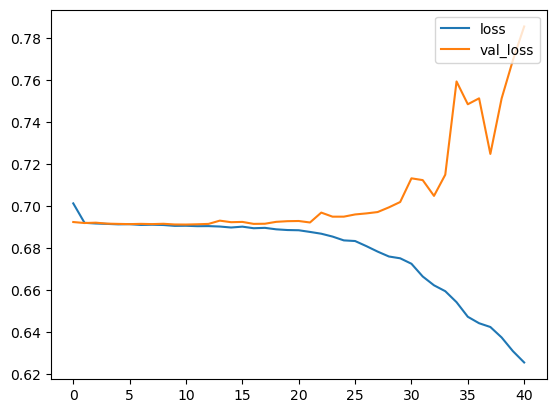

In [314]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

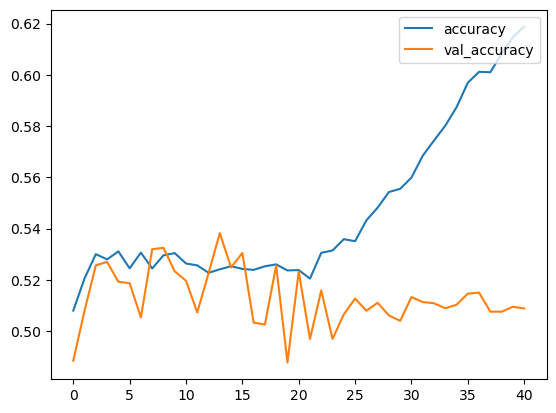

In [315]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
os.chdir('/home/manhducnmd/pp_dijet/Model_results')

Loading a sample model for testing

In [383]:
#loaded_model = keras.models.load_model('run_5_id10_500_25.keras')
loaded_model = cwola

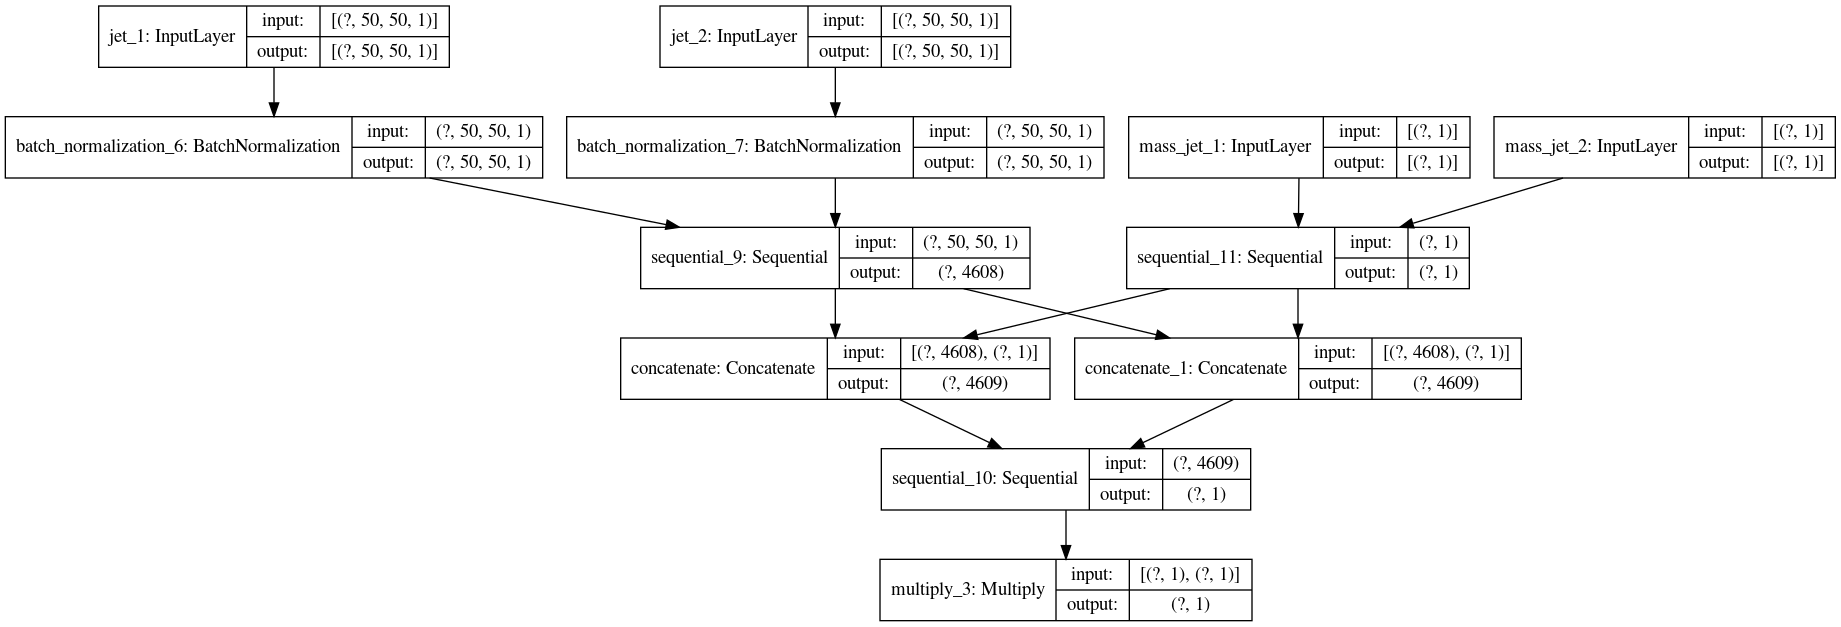

In [34]:
keras.utils.plot_model(loaded_model, "multi_input_and_output_model.png", show_shapes=True)

In [14]:
print(loaded_model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
jet_1 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
jet_2 (InputLayer)              [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 25, 25, 1)    4           jet_1[0][0]                      
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 25, 25, 1)    4           jet_2[0][0]                      
____________________________________________________________________________________________

In [198]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [346]:
print(signal_sb_lha_jet_2)

[0.3643233  0.2079619  0.29383322 ... 0.398844   0.5114936  0.66268079]


In [370]:
bkg_sr_jet_1 = np.load(f'retest_full_background_images_sr_50_jet_1.npy')
bkg_sr_jet_2 = np.load(f'retest_full_background_images_sr_50_jet_2.npy')

bkg_sr_mass_jet_1 = np.load(f'test_full_background_sr_mass_jet_1.npy')
bkg_sr_mass_jet_2 = np.load(f'test_full_background_sr_mass_jet_2.npy')

bkg_sr_eta_jet_1 = np.load(f'test_full_background_sr_eta_jet_1.npy')
bkg_sr_eta_jet_2 = np.load(f'test_full_background_sr_eta_jet_2.npy')

bkg_sr_phi_jet_1 = np.load(f'test_full_background_sr_phi_jet_1.npy')
bkg_sr_phi_jet_2 = np.load(f'test_full_background_sr_phi_jet_2.npy')

bkg_sr_lha_jet_1 = np.load(f'test_full_background_sr_lha_jet_1.npy')
bkg_sr_lha_jet_2 = np.load(f'test_full_background_sr_lha_jet_2.npy')

bkg_sr_all_variables_jet_1 = np.stack((bkg_sr_mass_jet_1, bkg_sr_lha_jet_1)
                                     , axis = -1)
bkg_sr_all_variables_jet_2 = np.stack((bkg_sr_mass_jet_2, bkg_sr_lha_jet_2)
                                     , axis = -1)

signal_sr_jet_1 = np.load(f'm_id10_sr_50_jet_1.npy')
signal_sr_jet_2 = np.load(f'm_id10_sr_50_jet_2.npy')

signal_sr_mass_jet_1 = np.load(f'id10_sr_mass_jet_1.npy')
signal_sr_mass_jet_2 = np.load(f'id10_sr_mass_jet_2.npy')

signal_sr_eta_jet_1 = np.load(f'id10_sr_eta_jet_1.npy')
signal_sr_eta_jet_2 = np.load(f'id10_sr_eta_jet_2.npy')

signal_sr_phi_jet_1 = np.load(f'id10_sr_phi_jet_1.npy')
signal_sr_phi_jet_2 = np.load(f'id10_sr_phi_jet_2.npy')

signal_sr_lha_jet_1 = np.load(f'id10_sr_lha_jet_1.npy')
signal_sr_lha_jet_2 = np.load(f'id10_sr_lha_jet_2.npy')

signal_sr_all_variables_jet_1 = np.stack((signal_sr_mass_jet_1, signal_sr_lha_jet_1), 
                                         axis = -1)
signal_sr_all_variables_jet_2 = np.stack((signal_sr_mass_jet_2, signal_sr_lha_jet_2)
                                         , axis = -1)

In [371]:
signal_test_1 = signal_sr_jet_1[-20000:]
signal_test_2 = signal_sr_jet_2[-20000:]
signal_test_all_variables_jet_1 = signal_sr_all_variables_jet_1[-20000:]
signal_test_all_variables_jet_2 = signal_sr_all_variables_jet_2[-20000:]


bkg_test_1 = bkg_sr_jet_1[-20000:]
bkg_test_2 = bkg_sr_jet_2[-20000:]
bkg_test_all_variables_jet_1 = bkg_sr_all_variables_jet_1[-20000:]
bkg_test_all_variables_jet_2 = bkg_sr_all_variables_jet_2[-20000:]


test_label_signal = np.ones(np.shape(signal_test_1)[0])
test_label_bkg = np.zeros(np.shape(bkg_test_1)[0])

x_test_1 = np.concatenate((signal_test_1, bkg_test_1))
x_test_2 = np.concatenate((signal_test_2, bkg_test_2))
x_test_all_variables_jet_1 = np.concatenate((signal_test_all_variables_jet_1, bkg_test_all_variables_jet_1))
x_test_all_variables_jet_2 = np.concatenate((signal_test_all_variables_jet_2, bkg_test_all_variables_jet_2))

y_test = np.concatenate((test_label_signal, test_label_bkg))

#x_test = np.stack([x_test_1, x_test_2], axis = -1)
x_test_1 = x_test_1.reshape((np.shape(x_test_1)[0],50,50,1))
x_test_2 = x_test_2.reshape((np.shape(x_test_2)[0],50,50,1))


In [384]:
x_predict = loaded_model.predict([x_test_1, x_test_2, x_test_all_variables_jet_1, x_test_all_variables_jet_2])

In [385]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]


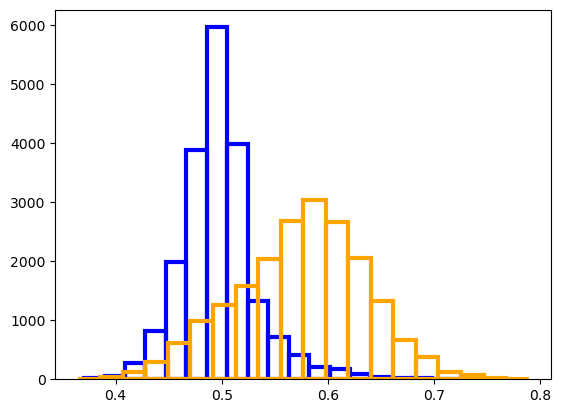

In [386]:
plt.hist(x_predict_0, bins = 20, color='blue', edgecolor='blue', fc="None", lw=3)
plt.hist(x_predict_1, bins = 20, color='orange', edgecolor='orange', fc="None", lw=3)
plt.show()

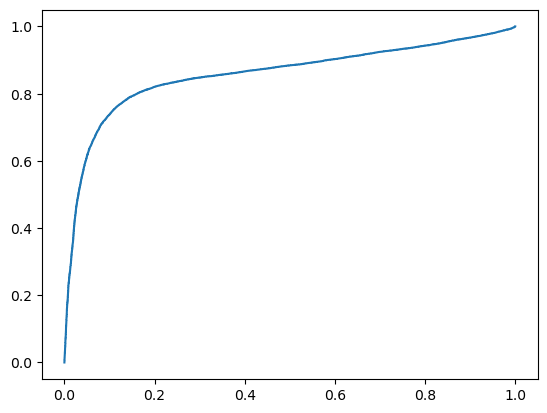

0.85750239


In [387]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

In [388]:
print(epsilon_s)

[0.0286 0.2415 0.738 ]


In [392]:
n_train_sr_signal = 600

In [395]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[2]+25000*0.1)*np.log(n_train_sr_signal*epsilon_s[2]/(25000*0.1) + 1) - 
                 n_train_sr_signal*epsilon_s[2])))

8.612163856953451
